### Import KD Libraries

In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import IPython.core.debugger as db
from pathlib import Path
from functools import partial
import math
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch import nn

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
gd_path = 'gdrive/My Drive/Colab Data/fastai-v3'  #change dir to your project folder
gn_path = 'gdrive/My Drive/Colab Notebooks'  #change dir to your project folder

import sys
sys.path.insert(1, gn_path + '/exp')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from nb_data import DisplayData, FeatureSet, FeatureList, TabularDataBundle
from nb_app import AppBase, AppTabular

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from nb_util import save_pickle, load_pickle, accuracy, DebugRand
#from nb_data import DataBundle, CSVItemContainer, DfItemList, SentenceItemList, SentenceWordItemList, SentenceWordIdItemList, SortishSampler, SortSampler
#from nb_training import Trainer, Callback, CudaCB, ProgressCallback, MetricsGrp, LossMetricsCB, AverageMetricsCB, DebugTracker, DebugYhatLossCB
from nb_training import Trainer, Callback, CudaCB, ProgressCallback, AverageMetricsCB
from nb_optimiser import HyperParams, Recorder
from nb_arch import ArchBase
from nb_app import TextTranslationCSVDataBundle, AppBase

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from nb_util import accuracy, accuracy_thresh, mse, rmspe, save_pickle, load_pickle, DebugRand
from nb_training import Trainer, CancelFitException, Callback, MetricsGrp, LossMetricsCB, AverageMetricsCB, RocAucMetricsCB, AbortTrainCB, ProgressCallback, CudaCB, DebugTracker, DebugYhatLossCB
#from nb_optimiser import get_optimiser, Recorder, adam_opt_func, HyperParams
from nb_optimiser import get_optimiser, Recorder, adam_opt_func, HyperParams, LRRangeFind
#from nb_hooks import Hooks, Hook
from nb_hooks import Hooks, DebugActivationHook
from nb_util import test_near_zero

### Rossmann Stores

In [ ]:
#----------------------------------------------------
# Tabular Rossman Forecast data preparation pipeline
#----------------------------------------------------
class TabularRossmanDataBundle(TabularDataBundle):
  def __init__(self, csv_path, test_csv_path, related_csv_paths, **kwargs):
    super().__init__(csv_path, test_csv_path, related_csv_paths, prepare_fn=self.prepare, test_data=True, **kwargs)
    self.split_params = {'split_procedure': 'split_custom', 'custom_fn': self.split_cutoff_date}

  # ----------------------------
  # Define data files
  # ----------------------------
  @staticmethod
  def get_data_files():
    data_files = {}
    data_files['main'] = 'train.csv'
    data_files['test'] = 'test.csv'
    data_files['related'] = ['store.csv', 'store_states.csv', 'state_names.csv', 'weather.csv', 'googletrend.csv']
    return data_files

  # ----------------------------
  # Define related dfs for creating subsets
  # ----------------------------
  @classmethod
  def subset_related(cls):
    idx_related = {'store': 'st', 'store_states': 'ss', 'state_names': 'sn', 'weather': 'we', 'googletrend': 'gt'}
    merge_fn = cls._merge_all
    return (idx_related, merge_fn)

  # ----------------------------
  # Split the data based on a cutoff date. All rows earlier than the cutoff date are taken
  # as training data, and rows later than the Date are taken as validation data.
  # The cutoff date is chosen based on the length of the test data, since we want the 
  # length of the validation data to be similar to the length of the test data.
  # ----------------------------   
  def split_cutoff_date(self):
    # Get train and test dfs
    train_df = self.all_rows.df
    test_df = self.all_rows.test_rows.df

    # !!!!!!! Temporarily use a cutoff len of 20% of train
    if (len(test_df) > (len(train_df) // 2)):
      cutoff_len = int(0.2 * len(train_df))
    else:
      cutoff_len = len(test_df)

    # Get all rows whose date matches the date of the row corresponding to the cutoff length
    cutoff_date_mask = (train_df[['Year', 'Month', 'Day']] == train_df.iloc[cutoff_len][['Year', 'Month', 'Day']]).all(1)

    # !!!!!!! Temporarily use a min() instead of max()
    if (len(test_df) > (len(train_df) // 2)):
      cutoff_idx = train_df[cutoff_date_mask].index.min()
    else:
      # Get the maximum index value of those rows
      cutoff_idx = train_df[cutoff_date_mask].index.max()

    # Make a list of row indexes
    num_idxs = len(train_df)
    idxs = list(range(num_idxs))

    # Since we've sorted in Descending order of the Date, the validation data is taken first.
    # In other words, the validation data corresponds to the most recent dates.
    valid_idxs = idxs[:cutoff_idx]
    train_idxs = idxs[cutoff_idx:]

    # Get the ItemLists of rows corresponding to those indexes
    train_rows, valid_rows, test_rows = self.all_rows.split_idxs(test_data=True, train_idxs=train_idxs, valid_idxs=valid_idxs)

    return (train_rows, valid_rows, test_rows)

  # ----------------------------
  # Merge all the related dfs into the main df
  # ----------------------------   
  @staticmethod   # So it can be used in make_subset() without needing an instance
  def _merge_all(il):
    # Split 'week' from 'start date - end date' into 'start date'
    il.text_split(df_name='googletrend', col='week', sep=' - ', new_cols=['Date'])
    # Slice off separate df for DE country-wide trend
    trend_de_df = il.googletrend_df[il.googletrend_df['file'] == 'Rossmann_DE']
    # Split 'file' from 'Rossmann_DE_state' into 'state'
    il.text_split(df_name='googletrend', col='file', sep='_', new_cols=[None, None, 'State'])
    # Update 'state' value of 'NI' with 'HB,NI' to make it consistent with other dfs
    il.text_replace(df_name='googletrend', col='State', old_val='NI', new_val='HB,NI')
    # Merge DE country_wide trend into 'googletrend', so every row has a state trend and a
    # country trend for each date
    il.join_df(df_name='googletrend', right_df=trend_de_df, left_on='Date', suffix='_DE')
    # Extract 'Year' and 'Week' from the 'Date' column
    il.extract_date(df_name='googletrend', col='Date', drop=False, attr=['Year', 'Week'])

    # Convert 'Date' column datatype to Datetime
    il.to_date(df_name='weather', col='Date')
    il.to_date(col='Date')
    # Merge the 'state names' into 'weather'
    il.join_df(df_name='weather', right_df_name='state_names', left_on='file', right_on='StateName')
    # Merge the 'store states' into 'store'
    il.join_df(df_name='store', right_df_name='store_states', left_on='Store')
    # Merge the 'store' into main
    il.join_df(right_df_name='store', left_on='Store')
    # Merge the 'weather' into main
    il.join_df(right_df_name='weather', left_on=['State','Date'])
    # Extract all Date metadata columns from the 'Date' column
    il.extract_date(col='Date', drop=False)
    # Merge the 'googletrend' into main
    il.join_df(right_df_name='googletrend', left_on=["State","Year", "Week"])

    # Merging completed. The related_dfs are no longer used after this
    # ---------------------------------------

  # ----------------------------
  # Basic features
  # ----------------------------   
  def _base_features(self, il):
    # Convert to bool. But values are characters not numbers
    il.df['StateHoliday'] = (il.df['StateHoliday'] != '0') & (il.df['StateHoliday'] != 0)
    # Convert from 0-1 numbers to bool
    il.num_01_to_bool(col='SchoolHoliday')

    # Remove duplicate columns
    il.remove_col(cols=['file', 'StateName'])

    # Custom logic to extract some features for Competition and Promos
    self.calc_competition_promo(il.df)

    # Add features for Days Since and Days Till the occurrence of events like 
    # School Holiday, State Holiday and Promo
    il.sort_by(sort_cols=['Store', 'Date'], ascending=[True, True])
    il.time_since(sort_col='Store', date_col='Date', col='SchoolHoliday', prefix='Since')
    il.time_since(sort_col='Store', date_col='Date', col='StateHoliday', prefix='Since')
    il.time_since(sort_col='Store', date_col='Date', col='Promo', prefix='Since')

    il.sort_by(sort_cols=['Store', 'Date'], ascending=[True, False])
    il.time_since(sort_col='Store', date_col='Date', col='SchoolHoliday', prefix='Till')
    il.time_since(sort_col='Store', date_col='Date', col='StateHoliday', prefix='Till')
    il.time_since(sort_col='Store', date_col='Date', col='Promo', prefix='Till')

    # Compute rolling window totals for School Holiday, State Holiday and Promo
    il.rolling_window(date_col='Date', group_cols=['Store'], window_sz=7, agg_cols=['SchoolHoliday', 'StateHoliday', 'Promo'], agg_fn='sum', ascending=True, suffix='_bw')
    il.rolling_window(date_col='Date', group_cols=['Store'], window_sz=7, agg_cols=['SchoolHoliday', 'StateHoliday', 'Promo'], agg_fn='sum', ascending=False, suffix='_fw')

    # Finally sort by Date first, then Store
    # !!!!!! We do this to be consistent with Fastai. Also Fastai splits validation first
    # and then train while we do the opposite, so we sort in the reverse direction
    il.sort_by(sort_cols=['Date', 'Store'], ascending=[False, True])

  # ----------------------------
  # Basic training columns
  # ----------------------------   
  def _prepare_base(self, il):
    self._merge_all(il)
    self._base_features(il)

    base_cat_cols = ['Store', 'DayOfWeek', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
        'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2Weeks',
       'Promo2SinceYear', 'PromoInterval', 'State', 'Year', 'Month', 'Week', 'Day', 'Dayofweek',
       'Dayofyear', 'Is_month_end', 'Is_month_start', 'Is_quarter_end',
       'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'CompetitionOpenSince', 
       'CompetitionMonthsOpen', 'Promo2Since', 
       'SchoolHoliday_bw', 'StateHoliday_bw', 'Promo_bw', 'SchoolHoliday_fw',
       'StateHoliday_fw', 'Promo_fw', 'Events']
    base_cont_cols = ['Max_TemperatureC', 'CompetitionDistance', 'CompetitionDaysOpen', 'Promo2Days', 
       'Mean_TemperatureC', 'Min_TemperatureC', 'Dew_PointC', 'MeanDew_PointC',
       'Min_DewpointC', 'Max_Humidity', 'Mean_Humidity', 'Min_Humidity',
       'Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
       'Min_Sea_Level_PressurehPa', 'Max_VisibilityKm', 'Mean_VisibilityKm',
       'Min_VisibilitykM', 'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h',
       'Max_Gust_SpeedKm_h', 'Precipitationmm', 'CloudCover',
       'WindDirDegrees', 'Elapsed', 'trend', 'trend_DE', 'SinceSchoolHoliday', 'SinceStateHoliday',
       'SincePromo', 'TillSchoolHoliday', 'TillStateHoliday', 'TillPromo']

    # !!!!!!!!!! 
    base_cat_cols = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen', 'Promo2Weeks', 'StoreType', 'Assortment',
       'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear', 'State', 'Week', 'Events',
      'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw', 'SchoolHoliday_fw', 'SchoolHoliday_bw']
    base_cont_cols=['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC', 'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'CloudCover', 
      'trend', 'trend_DE', 'SinceStateHoliday', 'TillStateHoliday', 'Promo', 'SchoolHoliday',]

    fs = FeatureSet('base', base_cat_cols, base_cont_cols)
    return (fs)

  # ----------------------------
  # Target columns
  # ----------------------------   
  def _prepare_tgt(self, il, is_test):
    cols_tgt = ['Sales', 'Customers']
    # !!!!!!!!!
    cols_tgt=['Sales']

    if (is_test):
      # Since the test data has no Target columns, add Target columns with dummy
      # data so that the same 'y' Extract and Convert logic that is used for the
      # training and validation data can be used for the test data
      for col in cols_tgt:
        il.df[col] = 1

    else:
      # !!!!!!! This may not be a good idea
      # Filter out rows where Sales or Customers is 0
      il.df.drop(il.df[(il.df['Sales'] == 0) | (il.df['Customers'] == 0)].index, inplace=True)

      # Maximum range of target values. Save it in the databundle.
      max_log_tgt = np.log(np.max(il.df['Sales']) * 1.2)
      self.tgt_range = (0, max_log_tgt)

      # Take log of the target columns
      il.df.loc[:, cols_tgt] = np.log(il.df[cols_tgt], dtype=np.float32)
      
    return cols_tgt

  # ----------------------------
  # Prepare and pre-process the data
  # ----------------------------   
  def prepare(self, il, is_test=False):
    fl = FeatureList()
    fs = self._prepare_base(il)
    fl.add_fs(fs)

    cols_tgt = self._prepare_tgt(il, is_test)

    il = super().prepare(il, fl, cols_tgt)
    return il

  # ----------------------------
  # Clean up data and extract some new features for Competition and Promo
  # ----------------------------
  @staticmethod
  def calc_competition_promo(df):
    # Fill in missing values with an arbitrary value that doesn't occur in the data
    df['CompetitionOpenSinceYear'] = df['CompetitionOpenSinceYear'].fillna(1900).astype(np.int32)
    df['CompetitionOpenSinceMonth'] = df['CompetitionOpenSinceMonth'].fillna(1).astype(np.int32)
    df['Promo2SinceYear'] = df['Promo2SinceYear'].fillna(1900).astype(np.int32)
    df['Promo2SinceWeek'] = df['Promo2SinceWeek'].fillna(1).astype(np.int32)

    # Extract two new features - date since competition opened, and how many days ago was it
    df["CompetitionOpenSince"] = pd.to_datetime(dict(year=df['CompetitionOpenSinceYear'], 
                                                     month=df['CompetitionOpenSinceMonth'], day=15))
    df["CompetitionDaysOpen"] = df['Date'].subtract(df['CompetitionOpenSince']).dt.days

    # Replace erroneous or outlying data
    df.loc[df['CompetitionDaysOpen']<0, "CompetitionDaysOpen"] = 0
    df.loc[df['CompetitionOpenSinceYear']<1990, "CompetitionDaysOpen"] = 0

    # Extract another feature "CompetitionMonthsOpen", limiting the maximum to 2 years 
    # to limit number of unique categories
    df['CompetitionMonthsOpen'] = df['CompetitionDaysOpen']//30
    df.loc[df['CompetitionMonthsOpen']>24, 'CompetitionMonthsOpen'] = 24

    #
    # Do similar processing for Promo
    #

    ! pip install isoweek
    from isoweek import Week
    df["Promo2Since"] = pd.to_datetime(df.apply(lambda x: Week(x['Promo2SinceYear'], x['Promo2SinceWeek']).monday(), 
                                                axis=1))
    df["Promo2Days"] = df['Date'].subtract(df['Promo2Since']).dt.days

    # Replace erroneous or outlying data
    df.loc[df['Promo2Days']<0, "Promo2Days"] = 0
    df.loc[df['Promo2SinceYear'] < 1990, "Promo2Days"] = 0

    # Extract another feature 'Promo Weeks', limit the max to 25 weeks
    df["Promo2Weeks"] = df["Promo2Days"] //7
    df.loc[df['Promo2Weeks']<0, "Promo2Weeks"] = 0
    df.loc[df['Promo2Weeks']>25, "Promo2Weeks"] = 25


**Set Data Paths**

In [ ]:
# Initially start with only the main data files without related files, create
# subsets and complete end-to-end models. Then incrementally add related files
# one at a time, build up the merge and prepare functions, and use them to
# create subsets.
app_dir='rossman'
subset_sz=6400
#subset_sz='full'
rossman_data_files = TabularRossmanDataBundle.get_data_files()
root_path, download_path, data_path, debug_path, hist_path, main_file_path, test_file_path, related_csv_paths = AppTabular.set_data_path (app_dir, gd_path, subset_sz, rossman_data_files)
root_path, download_path, data_path, debug_path, hist_path, main_file_path, test_file_path, related_csv_paths
pickle_dir = root_path/'pickle'

(PosixPath('/content'),
 PosixPath('/content/rossman'),
 PosixPath('gdrive/My Drive/Colab Data/fastai-v3/data/rossman_6400'),
 PosixPath('gdrive/My Drive/Colab Data/fastai-v3/data/rossman_6400/debug'),
 PosixPath('gdrive/My Drive/Colab Data/fastai-v3/data/rossman_6400/hist'),
 PosixPath('gdrive/My Drive/Colab Data/fastai-v3/data/rossman_6400/train.csv'),
 PosixPath('gdrive/My Drive/Colab Data/fastai-v3/data/rossman_6400/test.csv'),
 [PosixPath('gdrive/My Drive/Colab Data/fastai-v3/data/rossman_6400/store.csv'),
  PosixPath('gdrive/My Drive/Colab Data/fastai-v3/data/rossman_6400/store_states.csv'),
  PosixPath('gdrive/My Drive/Colab Data/fastai-v3/data/rossman_6400/state_names.csv'),
  PosixPath('gdrive/My Drive/Colab Data/fastai-v3/data/rossman_6400/weather.csv'),
  PosixPath('gdrive/My Drive/Colab Data/fastai-v3/data/rossman_6400/googletrend.csv')])

**Download data**

In [ ]:
if (subset_sz == 'full'):
  !wget http://files.fast.ai/part2/lesson14/rossmann.tgz

  import tarfile
  tf = tarfile.open('rossmann.tgz')
  tf.extractall(download_path)
  list(download_path.iterdir())

**Make Subset**

In [ ]:
# Initially TabularRossmanDataBundle will not override the subset_related method, so subsets will
# be created only for the main files. Later as you incrementally add related files, you can
# define that method and add files into it one by one

create_subset_sz=0
#create_subset_sz=100
if (create_subset_sz > 0):
  # Read full source data
  assert(subset_sz == 'full')
  rtdb = TabularDataBundle(main_file_path, test_file_path, related_csv_paths=related_csv_paths)

  # Create subset data of the given size
  idx_related, merge_fn = TabularRossmanDataBundle.subset_related()
  subset_data_path = AppTabular.subset_path(app_dir, gd_path, create_subset_sz)
  rtdb.make_subset(idx_related, merge_fn, subset_data_path, subset_sz=create_subset_sz)

**Exploratory Data Analysis**

In [ ]:
rtdb = TabularDataBundle(main_file_path, related_csv_paths=related_csv_paths)
train_il = rtdb.process(steps=['load'])

--------- Tabular Home Credit DataBundle init gdrive/My Drive/Colab Data/fastai-v3/data/rossman_6400/train.csv None [PosixPath('gdrive/My Drive/Colab Data/fastai-v3/data/rossman_6400/store.csv'), PosixPath('gdrive/My Drive/Colab Data/fastai-v3/data/rossman_6400/store_states.csv'), PosixPath('gdrive/My Drive/Colab Data/fastai-v3/data/rossman_6400/state_names.csv'), PosixPath('gdrive/My Drive/Colab Data/fastai-v3/data/rossman_6400/weather.csv'), PosixPath('gdrive/My Drive/Colab Data/fastai-v3/data/rossman_6400/googletrend.csv')]
gdrive/My Drive/Colab Data/fastai-v3/data/rossman_6400/store.csv memory reduced by 41.2% from 0.09 MB to 0.05 MB
gdrive/My Drive/Colab Data/fastai-v3/data/rossman_6400/store_states.csv memory reduced by 37.2% from 0.02 MB to 0.01 MB
gdrive/My Drive/Colab Data/fastai-v3/data/rossman_6400/state_names.csv memory reduced by 0.0% from 0.00 MB to 0.00 MB
gdrive/My Drive/Colab Data/fastai-v3/data/rossman_6400/weather.csv memory reduced by 64.8% from 0.03 MB to 0.01 MB
g

In [ ]:
train_il.df.sample()
train_il.store_df.sample()
train_il.store_states_df.sample()
train_il.weather_df.sample()
train_il.state_names_df.sample()
train_il.googletrend_df.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
3466,122,2,2015-07-28,12205,1376,1,1,0,1


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
879,880,a,c,4570.0,NaN,NaN,0,NaN,NaN,NaN


,Store,State
450,451,HE


,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,Mean_Sea_Level_PressurehPa,Min_Sea_Level_PressurehPa,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
38,RheinlandPfalz,2015-07-30,24,16,8,10,7,1,88,52,13,1018,1016,1014,31.0,16.0,10.0,23,10,NaN,0.0,6.0,Rain,228


,StateName,State
0,BadenWuerttemberg,BW


,file,week,trend
38,Rossmann_DE_ST,2015-07-26 - 2015-08-01,87


In [ ]:
train_il.store_states_df[train_il.store_states_df['State'] == 'HB,NI'].sample()

,Store,State
1052,1053,"HB,NI"


In [ ]:
train_il.state_names_df[train_il.state_names_df['State'] == 'HB,NI'].sample()

,StateName,State
5,Niedersachsen,"HB,NI"


In [ ]:
train_il.googletrend_df[train_il.googletrend_df['file'] == 'Rossmann_DE'].sample()

,file,week,trend
14,Rossmann_DE,2015-09-13 - 2015-09-19,77


In [ ]:
train_il.googletrend_df[train_il.googletrend_df['file'] == 'Rossmann_DE_NI'].sample()

,file,week,trend
18,Rossmann_DE_NI,2015-09-13 - 2015-09-19,74


In [ ]:
mds = rtdb.display_metadata(train_il)
features_dict = {
  'key'     : ['Store', 'Date'],
  'primary' : ['Open', 'Promo', 'StateHoliday', 'SchoolHoliday'],
  'target' : ['Sales', 'Customers'],
}
train_il.add_features_dict(features_dict, df_name=None, mds=mds)

,dtype,size,missing,% miss,mode,mode %,col_type,unique,min,mean,50%,max
Store,int16,6400,0,0.00,2,0.10,continuous,NaN,1.00,539.31,534.00,1115.00
DayOfWeek,int8,6400,0,0.00,3,17.40,continuous,NaN,1.00,3.52,3.00,7.00
Date,object,6400,0,0.00,2015-07-31,17.40,categorical,6,NaN,NaN,NaN,NaN
Sales,int16,6400,0,0.00,0,12.70,continuous,NaN,0.00,7416.38,7553.00,32547.00
Customers,int16,6400,0,0.00,0,12.70,continuous,NaN,0.00,709.43,684.00,4783.00
Open,int8,6400,0,0.00,1,87.30,secondary,NaN,0.00,0.87,1.00,1.00
Promo,int8,6400,0,0.00,1,87.10,secondary,NaN,0.00,0.87,1.00,1.00
StateHoliday,int8,6400,0,0.00,0,100.00,secondary,NaN,0.00,0.00,0.00,0.00
SchoolHoliday,int8,6400,0,0.00,1,69.80,secondary,NaN,0.00,0.70,1.00,1.00


In [ ]:
mds = rtdb.display_metadata(train_il, 'store')
features_dict = {
  'key'     : ['Store'],
  'primary' : ['StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'Promo2'],
}
train_il.add_features_dict(features_dict, df_name='store', mds=mds)

,dtype,size,missing,% miss,mode,mode %,col_type,unique,min,mean,50%,max
Store,int16,1115,0,0.00,1115,0.10,continuous,NaN,1.00,558.00,558.00,1115.00
StoreType,object,1115,0,0.00,a,54.00,categorical,4,NaN,NaN,NaN,NaN
Assortment,object,1115,0,0.00,a,53.20,categorical,3,NaN,NaN,NaN,NaN
CompetitionDistance,float32,1115,3,0.27,250.00,1.10,continuous,NaN,20.00,5404.90,2325.00,75860.00
CompetitionOpenSinceMonth,float32,1115,354,31.75,9.00,11.20,secondary,NaN,1.00,7.22,8.00,12.00
CompetitionOpenSinceYear,float32,1115,354,31.75,2013.00,7.40,secondary,NaN,1900.00,2008.67,2010.00,2015.00
Promo2,int8,1115,0,0.00,1,51.20,secondary,NaN,0.00,0.51,1.00,1.00
Promo2SinceWeek,float32,1115,544,48.79,14.00,7.30,secondary,NaN,1.00,23.60,22.00,50.00
Promo2SinceYear,float32,1115,544,48.79,2011.00,11.50,secondary,NaN,2009.00,2011.76,2012.00,2015.00
PromoInterval,object,1115,544,48.79,"Jan,Apr,Jul,Oct",30.00,secondary,3,NaN,NaN,NaN,NaN


In [ ]:
mds = rtdb.display_metadata(train_il, 'store_states')
features_dict = {
  'key'     : ['Store'],
  'primary' : ['State'],
}
train_il.add_features_dict(features_dict, df_name='store_states', mds=mds)

,dtype,size,missing,% miss,mode,mode %,col_type,unique,min,mean,50%,max
Store,int16,1115,0,0.00,1115,0.10,continuous,NaN,1.00,558.00,558.00,1115.00
State,object,1115,0,0.00,NW,25.70,categorical,12,NaN,NaN,NaN,NaN


In [ ]:
mds = rtdb.display_metadata(train_il, 'weather')
features_dict = {
  'key'     : ['file', 'Date'],
  'primary' : ['Mean_TemperatureC', 'Dew_PointC', 'Mean_Humidity'],
}
train_il.add_features_dict(features_dict, df_name='weather', mds=mds)

,dtype,size,missing,% miss,mode,mode %,col_type,unique,min,mean,50%,max
file,object,136,0,0.00,Hamburg,10.30,categorical,12,NaN,NaN,NaN,NaN
Date,object,136,0,0.00,2015-07-30,8.80,categorical,14,NaN,NaN,NaN,NaN
Max_TemperatureC,int8,136,0,0.00,20,16.20,continuous,NaN,15.00,20.29,20.00,30.00
Mean_TemperatureC,int8,136,0,0.00,16,25.70,continuous,NaN,11.00,15.67,16.00,21.00
Min_TemperatureC,int8,136,0,0.00,12,17.60,continuous,NaN,2.00,10.90,11.00,17.00
Dew_PointC,int8,136,0,0.00,12,14.70,continuous,NaN,7.00,12.85,13.00,18.00
MeanDew_PointC,int8,136,0,0.00,12,15.40,continuous,NaN,4.00,10.01,10.00,16.00
Min_DewpointC,int8,136,0,0.00,8,16.90,continuous,NaN,1.00,7.09,7.00,15.00
Max_Humidity,int8,136,0,0.00,100,29.40,continuous,NaN,63.00,92.01,94.00,100.00
Mean_Humidity,int8,136,0,0.00,55,5.90,continuous,NaN,43.00,69.20,69.50,95.00


In [ ]:
mds = rtdb.display_metadata(train_il, 'state_names')

,dtype,size,missing,% miss,mode,mode %,col_type,unique
StateName,object,12,0,0.00,Bayern,8.30,categorical,12
State,object,12,0,0.00,SH,8.30,categorical,12


In [ ]:
mds = rtdb.display_metadata(train_il, 'googletrend')
features_dict = {
  'key'     : ['file', 'week'],
  'primary' : ['trend'],
}
train_il.add_features_dict(features_dict, df_name='googletrend', mds=mds)

,dtype,size,missing,% miss,mode,mode %,col_type,unique,min,mean,50%,max
file,object,44,0,0.00,Rossmann_DE,9.10,categorical,13,NaN,NaN,NaN,NaN
week,object,44,0,0.00,2015-07-26 - 2015-08-01,29.50,categorical,4,NaN,NaN,NaN,NaN
trend,int8,44,0,0.00,82,6.80,continuous,NaN,59.00,76.91,78.50,92.00


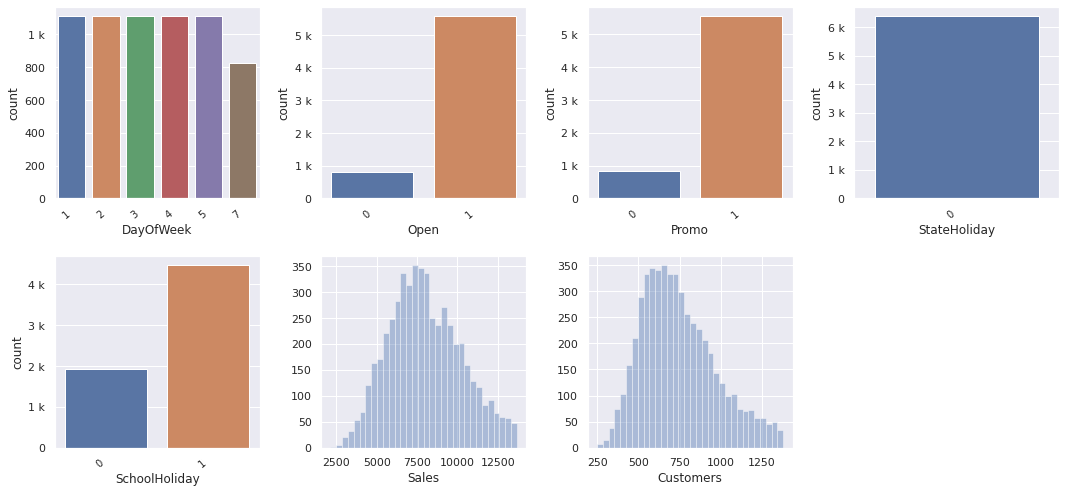

In [ ]:
DisplayData.data_distrib (train_il.df, ['DayOfWeek', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday'], ['Sales', 'Customers'])

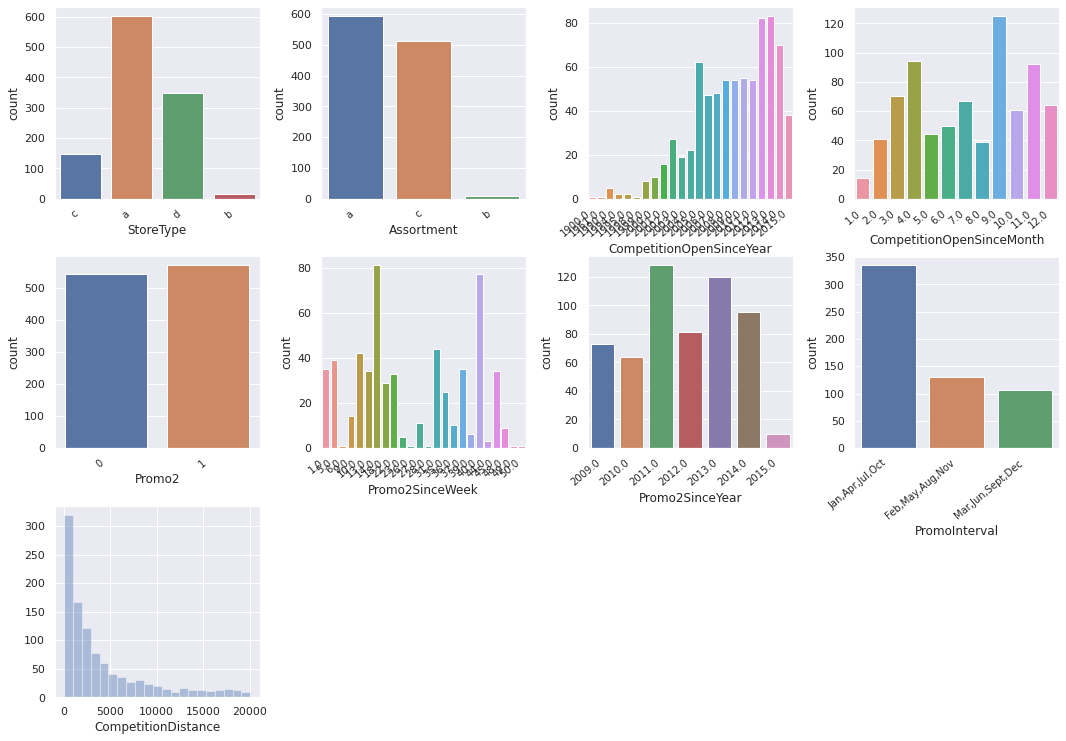

In [ ]:
DisplayData.data_distrib (train_il.store_df, ['StoreType', 'Assortment', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'], ['CompetitionDistance'])

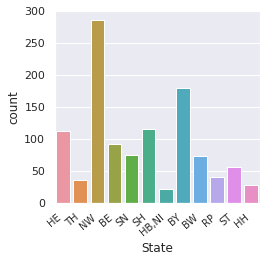

In [ ]:
DisplayData.data_distrib (train_il.store_states_df, ['State'], [])

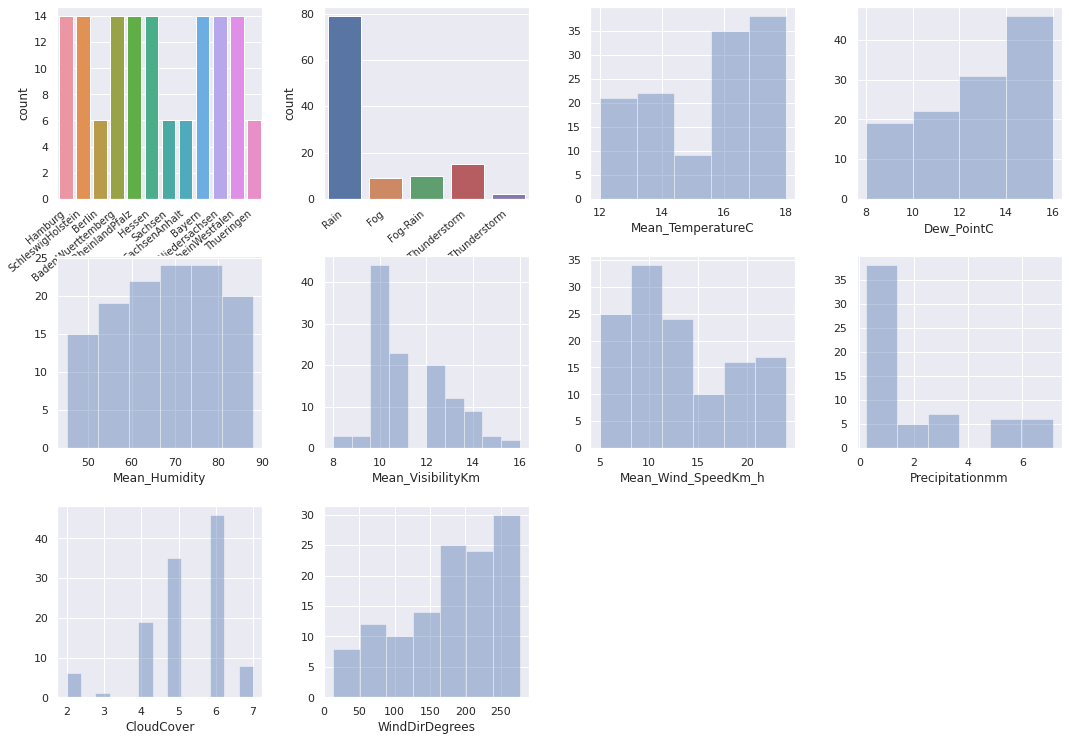

In [ ]:
DisplayData.data_distrib (train_il.weather_df, ['file', 'Events'], ['Mean_TemperatureC', 'Dew_PointC', 'Mean_Humidity', 'Mean_VisibilityKm', 'Mean_Wind_SpeedKm_h', 'Precipitationmm', 'CloudCover', 'WindDirDegrees'])

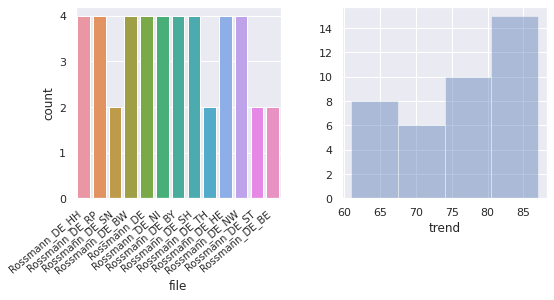

In [ ]:
DisplayData.data_distrib (train_il.googletrend_df, ['file'], ['trend'])

**Run Model**

In [ ]:
# --------- WORKFLOW ---------------
# 0. Set repro flag.
# 1. Prepare data and save pickle. Or Load pickle. ('debug/data_prep.pkl')
# 1a. Compare with prior saved data. ('hist/data_prep_2Jun.pkl')
# 2. Process data and save pickle. Or Load pickle ('debug/data_proc.pkl')
# 2a. Compare with prior saved data. ('hist/data_prep_2Jun.pkl')
# 1-2. Could combine Prepare + Process and save pickle as a single step. Or Load pickle.
# 3. Create arch. Load weights. ('debug/arch_wgts.mdl')
# 4. Create debug settings
# 5. Run model
# 6. Get results
# 6a. Display graphs
# 6b. Save good results ('hist/res_run_2Jun.pkl')
# 6c. Compare with prior runs

In [ ]:
trm_app = AppTabular(loss_type='regression', metrics_cbs=[AverageMetricsCB(rmspe)])
trm_app.load_data(TabularRossmanDataBundle, main_file_path, test_file_path, related_csv_paths, steps=['load'], add_flag=True)
save_pickle(trm_app, pickle_dir, 'prep_data.pkl')

In [ ]:
trm_app = load_pickle(pickle_dir/'prep_data.pkl')
trm_app.load_data(None, None, None, None, steps=['post_load'])
save_pickle(trm_app, pickle_dir, 'proc_data.pkl')

In [ ]:
trm_app = AppTabular(loss_type='regression', metrics_cbs=[AverageMetricsCB(rmspe)])
trm_app.load_data(TabularRossmanDataBundle, main_file_path, test_file_path, related_csv_paths)

save_pickle(trm_app, pickle_dir, 'proc_data.pkl')

In [ ]:
DebugRand.set_seed(0)
trm_app = load_pickle(pickle_dir/'proc_data.pkl')

trm_app.create_arch()
trm_app._arch.save_weights(pickle_dir/'arch_init_wgts.mdl')
trm_app._arch.load_weights(pickle_dir/'arch_init_wgts.mdl')

trm_app.create_debug(use_dtr=True, track_batches_per_epoch=15000, disp_tb=False, disp_pd=True, debug_bkwd=False, debug_fwd=False, abort_iter=0)

In [ ]:
find_lr = True
if (find_lr):
  loop = trm_app.lr_find(start_lr=1e-7, end_lr=10, num_iter=100)

In [ ]:
loop = trm_app.run_train(num_epochs=1, one_cycle=True)

epoch,tr_loss,smooth_loss,val_loss,rmspe,time
0,3.182612,3.199325,2.390237,4.097524,00:00


In [ ]:
# Results for Full Run of 1 + 5 epochs with Random Sampler
# 0	0.558723	0.016298	0.123937	03:16
# 0	0.019102	0.021872	0.137891	03:15
# 1	0.020525	0.020842	0.125883	03:13
# 2	0.018106	0.017409	0.120496	03:13
# 3	0.014663	0.014039	0.110326	03:14
# 4	0.011181	0.012315	0.103898	03:15

(None, None)

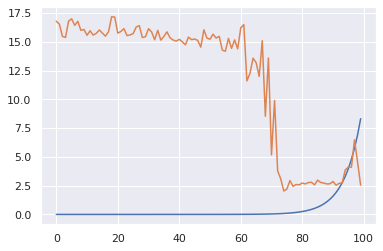

In [ ]:
recorder=loop.cbs[1]
recorder.plot_lr(), recorder.plot_loss()

In [ ]:
is_run_df, is_batch_df, is_layer_df, _ = loop.dtr.pd_results()
is_run_df
is_batch_df.head(2)
is_layer_df.head(2)

,run_id,num_epochs,row_type,epoch_id,num_tr_batches,num_val_batches,tr_loss,smooth_loss,val_loss,rmspe,time
0,Run-20200825_125006,1.0,run,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Run-20200825_125006,NaN,epoch,0.0,70.0,18.0,2.675224,2.674974,2.390237,4.097524,00:00


,run_id,row_type,epoch_id,batch_id,iter,batch_type,pred,loss,lr,mom,betas_2,eps,weight_decay,amsgrad
2,Run-20200825_125006,batch,0.0,0-0,0.0,train,10.572762,2.553154,0.000040,0.950000,0.99,1.000000e-08,0.2,False
3,Run-20200825_125006,batch,0.0,0-1,1.0,train,10.572762,2.668799,0.000045,0.949442,0.99,1.000000e-08,0.2,False


""


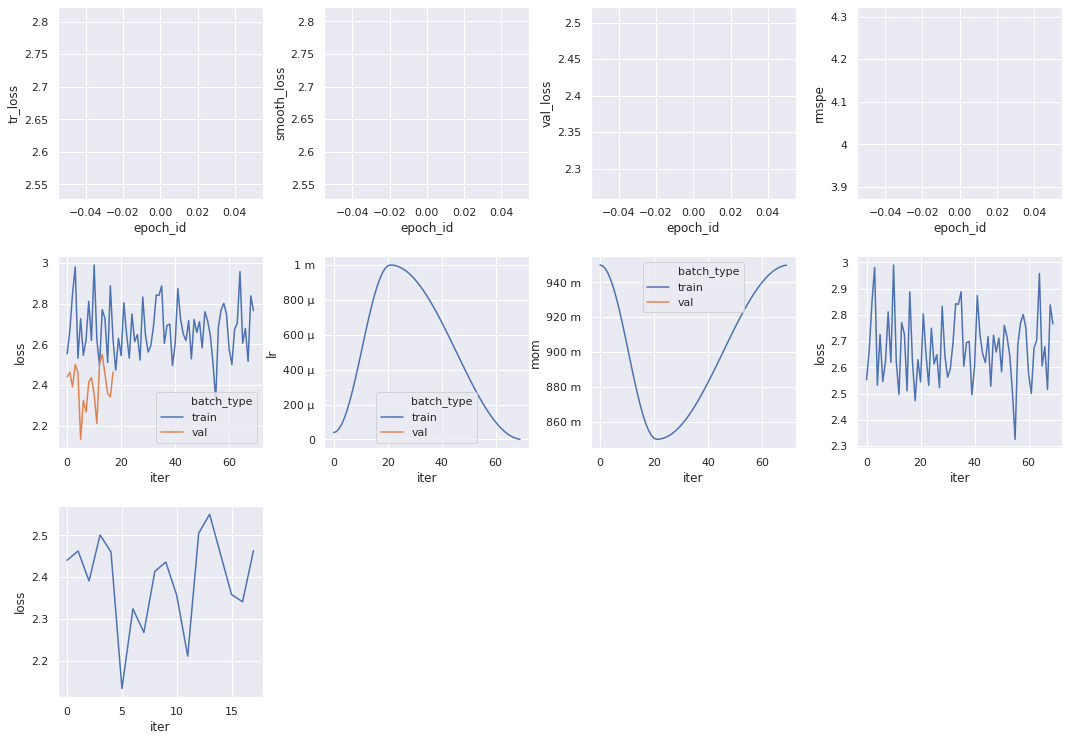

In [ ]:
loop.dtr.pd.display_metrics(is_run_df, is_batch_df, app_metrics=['rmspe'])

In [ ]:
!rm -r tbtry

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir tbtry

In [ ]:
last_good_run = '21Aug'
good_app = load_pickle(hist_path/f'{last_good_run}_proc_data.pkl')
trm_app.db.compare_db(trm_app.db, good_app.db)

Matched Training X
Matched Training Y
Matched Valid X
Matched Valid Y


[([], None, None), ([], None, None), ([], None, None), ([], None, None)]

In [ ]:
loop.dtr.load_run(hist_path/f'{last_good_run}_run.pkl')
_, good_batch_df, good_layer_df, _ = loop.dtr.pd_results()

loop.dtr.pd.compare_batch_results(is_batch_df, good_batch_df)
if ((len(is_layer_df) > 0) and (len(good_layer_df) > 0)):
  loop.dtr.pd.compare_activation_results(is_layer_df, good_layer_df)
  loop.dtr.pd.compare_param_results(is_layer_df, good_layer_df)

In [ ]:
#good_run = None
good_run = '21Aug'
if (good_run):
  debug_path.mkdir(exist_ok=True)
  trm_app._arch.save_weights(debug_path/'arch_trained_wgts.mdl')

  hist_path.mkdir(exist_ok=True)
  save_pickle(trm_app, hist_path, f'{good_run}_proc_data.pkl')
  loop.dtr.save_run(hist_path/f'{good_run}_run.pkl')

**Old**

In [ ]:
idx_related = {'store': 'st', 'store_states': 'ss', 'state_names': 'sn', 'weather': 'we', 'googletrend': 'gt'}
assert(load_full)
rtdb = TabularDataBundle(main_file_path, test_file_path, related_csv_paths=related_csv_paths)
rtdb.make_subset(idx_related, TabularRossmanDataBundle._merge_all, subset_data_path, nrows=640) # subset_data_path)

In [ ]:
torch.set_num_threads(1) # Default is 1. Same as on Fastai

root_path = Path.cwd()
download_path = root_path/'rossman'
#subset_data_path = Path(gd_path)/'data'/'rossman'
subset_data_path = Path(gd_path)/'data'/'rossman_6400'
#subset_data_path = Path(gd_path)/'data'/'rossman_64000'
#subset_data_path = Path(gd_path)/'data'/'rossman_640000'
#subset_data_path = Path(gd_path)/'data'/'rossman_full'
debug_path = subset_data_path/'debug'

load_full = False
if (load_full):
  data_path = download_path
else:
  data_path = subset_data_path

main_file_path = data_path/'train.csv'
test_file_path = data_path/'test.csv'
related_csv_paths = [data_path/'store.csv', data_path/'store_states.csv', data_path/'state_names.csv', data_path/'weather.csv', data_path/'googletrend.csv']

**OLD Run Model**

In [ ]:
trm_app = AppTabular(loss_type='regression', metrics_cbs=[AverageMetricsCB(rmspe)])
trm_app.load_data(TabularRossmanDataBundle, main_file_path, test_file_path, related_csv_paths)
trm_app.create_arch()
loop = trm_app.run_train(num_epochs=1, one_cycle=True)

In [ ]:
recorder=loop.cbs[1]
recorder.plot_lr(), recorder.plot_loss()

**OLD 0% Validation**

In [ ]:
class DebugRMDB(TabularRossmanDataBundle):
  def __init__(self, *args):
    super().__init__(*args)
    self.split_params = {'split_procedure': None}

In [ ]:
# 100% rows are train, no validation
rtdb = DebugRMDB(main_file_path, None, related_csv_paths)
rtdb.process()

**Compare 'Prepared' df with Fastai**

In [ ]:
rtdb = TabularRossmanDataBundle(main_file_path, None, related_csv_paths=related_csv_paths)
#rtdb.all_rows = rtdb._load(**rtdb.load_params)
rtdb.process(steps=['load'])
# Compare only categorical and continuous columns. Target column will be compared later in the Processed Data stage
fcol = rtdb.all_rows._categorical_cols() + rtdb.all_rows._continuous_cols()
kddf = rtdb.all_rows.df.drop(columns=['Sales']).reset_index(drop=True)
#kddf.head()

In [ ]:
faidf = pd.read_pickle(debug_path/'faidf')
faidf.drop(columns=['Sales', 'Date'], inplace = True)
faidf.columns = fcol
#faidf.head()

In [ ]:
compare_df(kddf, faidf)

**Temp Delete**

In [ ]:
diffdf = (kddf == faidf).all(0)
ucols = diffdf[~diffdf].index.tolist()

# Filter out columns which differ only in the NaN values
unmatched_cols=[]
for col in ucols:
  if (kddf[kddf[col].notna()][col] == faidf[faidf[col].notna()][col]).all(0):
    pass
  else:
    unmatched_cols.append(col)
ucols, unmatched_cols

In [ ]:
unmatch_mask = (kddf[unmatched_cols] != faidf[unmatched_cols]).any(1)
len(kddf[unmatch_mask][unmatched_cols]), len(faidf[unmatch_mask][unmatched_cols])
kddf[unmatch_mask][unmatched_cols].head(2)
faidf[unmatch_mask][unmatched_cols].head(2)

In [ ]:
def old_compare_kdfa(rtdb, tr_file, val_file):
  kdtrdf = rtdb.train_ds.x.df.reset_index(drop=True)
  faitrdf = pd.read_pickle(debug_path/tr_file)
  utrcols, unmatchedtr_cols = old_compare_df(kdtrdf, faitrdf)

  if (val_file):
    kdvaldf = rtdb.valid_ds.x.df.reset_index(drop=True)
    faivaldf = pd.read_pickle(debug_path/val_file)
    uvalcols, unmatchedval_cols = compare_df(kdvaldf, faivaldf)
  else:
    uvalcols, unmatchedval_cols = None, None

  return (utrcols, unmatchedtr_cols, uvalcols, unmatchedval_cols)

def old_compare_df(kdf, fdf):
  #fdf = fdf.sort_values(['Date', 'Store'], ascending=[True, False]).reset_index(drop=True)
  fdf = fdf.reset_index(drop=True)
  fdf.drop(columns=['Sales', 'Date'], inplace = True)
  fdf.columns = kdf.columns

  diffdf = (kdf == fdf).all(0)
  ucols = diffdf[~diffdf].index.tolist()

  # Filter out columns which differ only in the NaN values
  unmatched_cols=[]
  for col in ucols:
    if (kdf[kdf[col].notna()][col] == fdf[fdf[col].notna()][col]).all(0):
      pass
    else:
      unmatched_cols.append(col)

  return (ucols, unmatched_cols)

In [ ]:
kdpdf = rtdb.valid_ds.x.df.reset_index(drop=True)
kdpdf.head(3)

In [ ]:
faipdf = pd.read_pickle(debug_path/'faipdf_val')
#faipdf = faipdf.sort_values(['Date', 'Store'], ascending=[True, False]).reset_index(drop=True)
faipdf = faipdf.reset_index(drop=True)
faipdf.drop(columns=['Sales', 'Date'], inplace = True)
faipdf.columns = kdpdf.columns
faipdf.head(3)

In [ ]:
diffpdf = (kdpdf == faipdf).all(0)
upcols = diffpdf[~diffpdf].index.tolist()

# Filter out columns which differ only in the NaN values
unmatchedp_cols=[]
for col in upcols:
  if (kdpdf[kdpdf[col].notna()][col] == faipdf[faipdf[col].notna()][col]).all(0):
    pass
  else:
    unmatchedp_cols.append(col)
upcols, unmatchedp_cols

In [ ]:
unmatchp_mask = (kdpdf[unmatchedp_cols] != faipdf[unmatchedp_cols]).any(1)
kdpdf[unmatchp_mask][unmatchedp_cols].head()
faipdf[unmatchp_mask][unmatchedp_cols].head()

**Compare 'Processed' data with Fastai**

In [ ]:
rtdb = TabularRossmanDataBundle(main_file_path, test_file_path, related_csv_paths=related_csv_paths, add_flag=True)
rtdb.process()

In [ ]:
def compare_kdfa(rtdb, tr_file, val_file):
  kdtrdf = rtdb.train_ds.x.df.reset_index(drop=True)
  faitrdf = pd.read_pickle(debug_path/tr_file).reset_index(drop=True)
  faitrdf.drop(columns=['Sales', 'Date'], inplace = True)
  faitrdf.columns = kdtrdf.columns
  unmatchedtr = compare_df(kdtrdf, faitrdf, name='Training')

  if (val_file):
    kdvaldf = rtdb.valid_ds.x.df.reset_index(drop=True)
    faivaldf = pd.read_pickle(debug_path/val_file).reset_index(drop=True)
    faivaldf.drop(columns=['Sales', 'Date'], inplace = True)
    faivaldf.columns = kdvaldf.columns
    unmatchedval = compare_df(kdvaldf, faivaldf, name='Valid')
  else:
    unmatchedval = None, None

  return (unmatchedtr + unmatchedval)

In [ ]:
unmatched_kdfa = compare_kdfa(rtdb, 'faipdf_tr', 'faipdf_val')
unmatched_kdfa

**Compare 'model array/tensor' data with Fastai**

In [ ]:
faidata = load_pickle(debug_path/'faidata_trval.pkl')
faidata.train_ds.x.codes.shape, faidata.train_ds.x.conts.shape, faidata.valid_ds.x.codes.shape, faidata.valid_ds.x.conts.shape

In [ ]:
# Compare all categorical columns
(rtdb.train_ds.x.arr[:, :24] == faidata.train_ds.x.codes).all(0)
(rtdb.valid_ds.x.arr[:, :24] == faidata.valid_ds.x.codes).all(0)

In [ ]:
# Compare all continuous columns - all are equal except the type is float64
(rtdb.train_ds.x.arr[:, 24:].astype(np.float32) == faidata.train_ds.x.conts).all(0)
(rtdb.valid_ds.x.arr[:, 24:].astype(np.float32) == faidata.valid_ds.x.conts).all(0)

In [ ]:
# Compare the target columns - all are equal. Reshape so shapes are the same.
rtdb.train_ds.y.arr.shape, np.log(faidata.train_ds.y.items).shape, rtdb.valid_ds.y.arr.shape, np.log(faidata.valid_ds.y.items).shape
(rtdb.train_ds.y.arr.squeeze() == np.log(faidata.train_ds.y.items)).all()
(rtdb.valid_ds.y.arr.squeeze() == np.log(faidata.valid_ds.y.items)).all()

**Load Prepared and Processed Data as two steps**

In [ ]:
trm_app = AppTabular(loss_type='regression', metrics_cbs=[AverageMetricsCB(rmspe)])
trm_app.load_data(TabularRossmanDataBundle, main_file_path, test_file_path, related_csv_paths, steps=['load'])
save_pickle(trm_app, pickle_dir, 'prep_data.pkl')

In [ ]:
trm_app = load_pickle(pickle_dir/'prep_data.pkl')
trm_app.load_data(TabularRossmanDataBundle, main_file_path, test_file_path, related_csv_paths, steps=['post_load'])

**Compare Data Bundle to previous run**

In [ ]:
save_pickle(trm_app, pickle_dir, 'gold_data.pkl')

In [ ]:
gold_app = load_pickle(pickle_dir/'gold_data.pkl')
compare_db(trm_app.db, gold_app.db)

**Reproducibility**

In [ ]:
from nb_util import DebugRand
DebugRand.repro = True
DebugRand.set_seed(555)
torch.randn(4)
DebugRand.show_state()

# For reproducibility
#  Minimum requirement for fully reproducible results is DebugRand.set_seed
#  Two more optional items are (1) DataBundle sampler = Sequential Sampler and (2) Load model weights

In [ ]:

def tryit():
  DebugRand.set_seed(0)
  count = 2
  for i in range(count):
    print(torch.get_rng_state().float().mean())
    #db.set_trace()
    xb, yb = next(iter(trm_app.db.train_dl))
    print(xb[:, :24].float().mean(), xb[:, 24:].mean(), yb.mean())

DebugRand.set_seed(0)
trm_app = load_pickle(pickle_dir/'proc_data.pkl')

#tryit()

trm_app.create_arch()
trm_app.create_debug(use_dtr=True, track_batches_per_epoch=15000, disp_tb=False, disp_pd=True, debug_bkwd=True, debug_fwd=True, abort_iter=0)
rename_wgt_keys(trm_app._arch.model, debug_path/'faiarch_trval.mdl')
#init_param_df = print_grad(None, trm_app._arch.model)
DebugRand.set_seed(0)
loop = trm_app.run_train(num_epochs=1, one_cycle=True)

In [ ]:
faidata = load_pickle(debug_path/'faidata_repro.pkl')
# Has num_workers = 0, drop_last=False, shuffle=True

In [ ]:
# Fastai Dataloader
def tryit():
  DebugRand.set_seed(0)
  count = 4
  for i in range(count):
    print(torch.get_rng_state().float().mean())
    #db.set_trace()
    xb, yb = next(iter(faidata.train_dl))
    print(xb[0].float().mean(), xb[1].mean(), yb.mean())

tryit()

In [ ]:
save_pickle(faidata, debug_path, 'faidata_repro.pkl')

**Compare model execution with Fastai**

In [ ]:
trm_app = AppTabular(loss_type='regression', metrics_cbs=[AverageMetricsCB(rmspe)])
trm_app.load_data(TabularRossmanDataBundle, main_file_path, test_file_path, related_csv_paths, add_flag=True)

save_pickle(trm_app, pickle_dir, 'proc_data.pkl')

In [ ]:
DebugRand.set_seed(0)
trm_app = load_pickle(pickle_dir/'proc_data.pkl')

# Fastai doesn't run training for the last partial batch. So we truncate our training data to the last complete batch
trunc = int(len(trm_app.db.train_ds) / 64) * 64
trm_app.db.train_ds.x.items=trm_app.db.train_ds.x.items[:trunc]

trm_app.create_arch()
trm_app.create_debug(use_dtr=True, track_batches_per_epoch=15000, disp_tb=False, disp_pd=True, debug_bkwd=True, debug_fwd=True, abort_iter=0)
rename_wgt_keys(trm_app._arch.model, debug_path/'faiarch_trval.mdl')
init_param_df = print_grad(None, trm_app._arch.model)

#trm_app._arch.load_weights(pickle_dir/'arch_wgts.mdl')
loop = trm_app.run_train(num_epochs=1, one_cycle=True)
#trm_app._arch.save_weights(pickle_dir/'arch_wgts.mdl')

In [ ]:
# epoch	tr loss	val loss	rmspe	time
# 0	0.450476	0.015242	0.124391 (FULL Random)
# 0	0.562106	43.798592	3.185306	04:34 (FULL Sequential)
# 0	11.283821	1.309186	1.335522  (6400 Sequential)
def tryit():
  db.set_trace()
  loop = trm_app.run_train(num_epochs=1, one_cycle=True, use_dtr=True)

tryit()

In [ ]:
init_param_df

In [ ]:
loop = trm_app.run_train(num_epochs=1, use_dtr=True)

In [ ]:
recorder=loop.cbs[1]
recorder.plot_lr(), recorder.plot_loss()

In [ ]:
is_run_df, is_batch_df, is_layer_df, _ = loop.dtr.pd_results()
is_run_df
is_batch_df
is_layer_df

In [ ]:
is_layer_df[(is_layer_df['step_type'] == 'activation') & (is_layer_df['batch_type'] == 'train') & (is_layer_df['iter'] == 0.0)]

In [ ]:
run_gpu=True
if (run_gpu):
  init_param_df.to_pickle(debug_path/'kd_gpu_trval_init_param_df')
  is_batch_df.to_pickle(debug_path/'kd_gpu_trval_is_batch_df')
  is_layer_df.to_pickle(debug_path/'kd_gpu_trval_is_layer_df')  
else:
  init_param_df.to_pickle(debug_path/'kd_cpu_init_param_df')
  is_layer_df.to_pickle(debug_path/'kd_cpu_is_layer_df')
  is_batch_df.to_pickle(debug_path/'kd_cpu_is_batch_df')

**Visualise results**

In [ ]:
def WAITdisplay_metrics(df):
  p = Plotter()
  p.create_subplot ('line', df, 'iter', 'loss', hue="batch_type")
  p.create_subplot ('line', df, 'iter', 'lr', hue="batch_type")
  p.create_subplot ('line', df, 'iter', 'mom', hue="batch_type")
  #p.create_subplot ('line', df[df['batch_type'] == 'train'], 'iter', 'loss')
  #p.create_subplot ('line', df[df['batch_type'] == 'val'], 'iter', 'loss')

# ------ Below methods on DTR Pandas

def display_metrics(df):
  p = Plotter()
  p.plot_grid ('line', df, ['loss', 'lr', 'mom'], 'iter', hue="batch_type")

display_metrics(is_batch_df)

In [ ]:
is_layer_df[is_layer_df['step_type'] == 'activation']['layer_name'].unique()

In [ ]:
def display_layer(df):
  p = Plotter()
  p.create_subplot ('line', df[df['layer_name'] == 'cat_emb.1'], x='iter', y="out_activation", hue="batch_type")
  p.create_subplot ('line', df[df['layer_name'] == 'cat_emb.2'], x='iter', y="out_activation", hue="batch_type")
  p.create_subplot ('line', df[df['layer_name'] == 'cat_emb.3'], x='iter', y="out_activation", hue="batch_type")

  p.create_subplot ('line', df[df['layer_name'] == 'cat_emb.1.weight'], x='iter', y="grad_mean")
  p.create_subplot ('line', df[df['layer_name'] == 'cat_emb.1.weight'], x='iter', y="param_mean")

display_layer(is_layer_df)

In [ ]:
def display_layer(df):
  p = Plotter()
  p.create_subplot ('line', df[df['layer_name'] == 'cat_emb.1'], x='iter', y="out_activation", hue="batch_type")

In [ ]:
is_batch_df = is_batch_df.reset_index(drop=True)

In [ ]:
import seaborn as sns
sns.lineplot(x='iter', y="loss", hue="batch_type", data=is_batch_df)

In [ ]:
import seaborn as sns
sns.lineplot(x=is_batch_df.index, y="loss", hue="batch_type", data=is_batch_df)

In [ ]:
sns.lineplot(x='iter', y="lr", data=is_batch_df)

In [ ]:
sns.lineplot(x='iter', y="mom", data=is_batch_df)

In [ ]:
is_batch_df[['lr']].plot()
is_batch_df[['mom']].plot()

In [ ]:
is_layer_df = is_layer_df.reset_index(drop=True)

In [ ]:
is_layer_df[(is_layer_df['step_type'] == 'activation') & (is_layer_df['batch_type'] == 'train') & (is_layer_df['iter'] < 1.0)]

In [ ]:
sns.lineplot(x='step_id', y="out_activation", hue="layer_name", data=is_layer_df[is_layer_df['step_type'] == 'activation'])

In [ ]:
sns.lineplot(x='step_id', y="grad_mean", hue="layer_name", data=is_layer_df[(is_layer_df['step_type'] == 'param') & (is_layer_df['layer_name'].isin(['cat_emb.1.weight', 'cat_emb.2.weight']))])

In [ ]:
!rm -r tbtry

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir tbtry

**nn.Linear and torch.addmm**

In [ ]:
def fix_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
import IPython.core.debugger as db
from pathlib import Path
import random
import numpy as np
import torch
import torch.nn as nn

subset_data_path = Path(gd_path)/'data'/'rossman'
debug_path = subset_data_path/'debug'

def do_lin():
  n_in, n_out = 156, 1000
  fix_seeds(0)
  lin = nn.Linear(n_in, n_out).cuda()

  kd_inp = torch.load(debug_path/'lin_inp.tns')
  kd_wgt = torch.load(debug_path/'lin_wgt.tns')
  kd_bias = torch.load(debug_path/'lin_bias.tns')
  kd_out = torch.load(debug_path/'lin_outp.tns')

  lin.state_dict()['weight'].copy_(kd_wgt.data)
  lin.state_dict()['bias'].copy_(kd_bias.data)

  fai_lin_out = lin(kd_inp)
  eq_lin_out = torch.all(torch.eq(kd_out, fai_lin_out))
  diff_lin_out = fai_lin_out - kd_out

  fai_addmm_out = torch.addmm(kd_bias, kd_inp, kd_wgt.t())
  eq_addmm_out = torch.all(torch.eq(kd_out, fai_addmm_out))
  eq_faddmm_out = torch.all(torch.eq(fai_lin_out, fai_addmm_out))
  diff_addmm_out = fai_lin_out - kd_out
  print (eq_addmm_out, eq_faddmm_out)
  db.set_trace()

  if (False):
          ivs = [iv for iv in i]
          eq_inp = torch.all(torch.eq(kd_inp, ivs[0]))
          
          eq_wgt = torch.all(torch.eq(kd_wgt, m.weight))
          eq_bias = torch.all(torch.eq(kd_bias, m.bias))

do_lin()

**Process Fastai data in this notebook**

In [ ]:
fai_df = pd.read_pickle(debug_path/'faidf')
dep_var = 'Sales'
#valid_sz=41395
valid_sz=fai_df[fai_df['Date'] == fai_df.iloc[int(0.2 * len(fai_df))]['Date']].index.min()
valid_idx = range(valid_sz)
valid_sz, len(fai_df)

In [ ]:
from fastai.tabular import *
procs=[FillMissing, Categorify, Normalize]
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [ ]:
#path=subset_data_path
path=data_path    # For full only

def tryit():
  db.set_trace()
  faidata = (TabularList.from_df(fai_df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                #.add_test(TabularList.from_df(test_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch(bs=64))
  print(faidata.train_dl.sampler)
  #assert(data.train_dl.sampler == torch.utils.data.sampler.SequentialSampler)
  return faidata

faidata = tryit()

In [ ]:
# Save the processed df and then reload it in the data_lib notebook for comparison
if (valid_sz == 0):
  faidata.train_ds.x.inner_df.to_pickle(debug_path/'faipdf')
  save_pickle(faidata, debug_path, 'faidata.pkl')
  #save_pickle(faidata, debug_path, 'faidata_cpu.pkl')
else:
  faidata.train_ds.x.inner_df.to_pickle(debug_path/'faipdf_tr')
  faidata.valid_ds.x.inner_df.to_pickle(debug_path/'faipdf_val')
  save_pickle(faidata, debug_path, 'faidata_trval.pkl')

**Run Fastai model in this notebook**

In [ ]:
from fastai.tabular import *
fai_df = pd.read_pickle(debug_path/'faidf')
data = load_pickle(debug_path/'faidata_trval.pkl')
#data = faidata
#data = load_pickle(debug_path/'faidata_cpu.pkl')

In [ ]:
class KDDebug(LearnerCallback):
  def on_train_begin(self, **kwargs):
    self.all_params = []
    self.all_preds = []
    self.all_losses = []
    self.smooth_losses = []
    self.batch_type = []
    self.metrics = []
    self.batch_id = []
    self.lrs = []
    self.moms = []

  def on_loss_begin(self, last_output, last_target, **kwargs:Any)->None:
    self.all_preds.append (last_output.detach().mean().item())
    self.lrs.append(self.opt.lr)
    self.moms.append(self.opt.mom)

  #def on_backward_begin(self, last_loss, **kwargs:Any)->None:
  #  self.all_losses.append (last_loss.detach().item())

  def on_backward_end(self, smooth_loss, **kwargs:Any)->None:
    #self.smooth_losses.append (smooth_loss.detach().item())
    model = self.learn.model
    for name, param in model.named_parameters():
      param_dict = {'layer_name': name, 'shape': tuple(param.data.size()), 'requires': param.requires_grad, 
                    'leaf': param.is_leaf, 'param': param.data.float().mean().item(), 
                    'grad': (param.grad.mean().item() if param.grad is not None else 0)}
      self.all_params.append(param_dict)

  def on_batch_end(self, epoch, num_batch, last_loss, smooth_loss, train, **kwargs:Any)->None:
    self.all_losses.append (last_loss.detach().item())
    self.batch_id.append (f'{epoch}-{num_batch}')
    if (train):
      self.smooth_losses.append (smooth_loss.detach().item())
      self.batch_type.append ('train')
    else:
      self.smooth_losses.append ('0.0')
      self.batch_type.append ('val')

  def on_epoch_end(self, last_metrics, **kwargs:Any)->None:
    self.metrics.append(last_metrics)

from fastai.callbacks import *
class KDActivationHook(HookCallback):
    "Callback that record the mean and std of activations."

    def on_train_begin(self, **kwargs):
        "Initialize stats."
        super().on_train_begin(**kwargs)
        self.stats = []
        self.batch_type = []
        self.batch_id = []

    def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return o.mean().item(), o.std().item()
  
    def on_batch_end(self, epoch, num_batch, train, **kwargs):
        "Take the stored results and puts it in `self.stats`"

        self.stats.append(self.hooks.stored)
        self.batch_id.append (f'{epoch}-{num_batch}')
        if (train):
          self.batch_type.append ('train')
        else:
          self.batch_type.append ('val')

    def on_train_end(self, **kwargs):
        "Polish the final result."
        super().on_train_end(**kwargs)
        self.stats = tensor(self.stats).permute(2,1,0)

def loop_results(learn):
  act_hook = learn.kd_activation_hook

  num_batches = act_hook.stats.shape[2]
  num_modules = len(act_hook.modules)
  mods = act_hook.modules * num_batches
  acts = act_hook.stats.permute(0, 2, 1)[0, :, :].tolist()
  acts = [act for batch in acts for act in batch]
  batch_types = [bt for bt in act_hook.batch_type for _ in range(num_modules)] 
  batch_ids = [bi for bi in act_hook.batch_id for _ in range(num_modules)]
  act_df = pd.DataFrame({'layer_name': mods, 'out_activation': acts, 'f_batch_type': batch_types, 'f_batch_id': batch_ids})

  param_cb = learn.kd_debug
  param_df = pd.DataFrame(param_cb.all_params)

  loss_df = pd.DataFrame({'pred': param_cb.all_preds, 'loss': param_cb.all_losses, 'sm_loss': param_cb.smooth_losses, 'f_lr': param_cb.lrs, 'f_mom': param_cb.moms, 'f_batch_type': param_cb.batch_type, 'f_batch_id': param_cb.batch_id})

  return (act_df, param_df, loss_df)

In [ ]:
DebugRand.set_seed(0)
max_log_y = np.log(np.max(fai_df['Sales'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe, callback_fns=[KDDebug, KDActivationHook])
ArchTabular.load_weights(learn, debug_path/'faiarch_trval.mdl')
init_param_df = print_grad(None, learn.model)

def tryit():
  #DebugRand.set_seed(0)
  db.set_trace()
  learn.fit_one_cycle(1, 1e-3, wd=0.2)
  #learn.fit(1, 1e-3, wd=0.2)

tryit()
act_df, param_df, loss_df = loop_results(learn)

In [ ]:
learn.fit_one_cycle(5, 1e-3, wd=0.2)

In [ ]:
learn.recorder.plot_losses()

**Compare loss results with KD model**

In [ ]:
kd_batch_df = pd.read_pickle(debug_path/'kd_gpu_trval_is_batch_df')

In [ ]:
#kd_loss_df = kd_batch_df[(kd_batch_df['batch_type'] == 'val')][['pred', 'loss']].reset_index(drop=True)
kd_loss_df = kd_batch_df[['batch_id', 'batch_type', 'pred', 'loss', 'lr']].reset_index(drop=True)
len_kd_loss = len(kd_loss_df)
#fai_loss_df = loss_df[(loss_df['batch_type'] == 'val')][:len_kd_loss].reset_index(drop=True)
fai_loss_df = loss_df[:len_kd_loss].reset_index(drop=True)
fai_loss_df['diff_pred'] = kd_loss_df['pred'] - fai_loss_df['pred']
fai_loss_df['diff_loss'] = kd_loss_df['loss'] - fai_loss_df['loss']
fai_loss_df['diff_lr'] = kd_loss_df['lr'] - fai_loss_df['f_lr']
diff_loss = pd.concat([kd_loss_df, fai_loss_df], axis=1)
diff_loss[(diff_loss['diff_loss'] != 0.0)]
#diff_loss[diff_loss['batch_type'] == 'val'].index.min()

**Compare forward activation results with KD model**

In [ ]:
kd_is_layer_df = pd.read_pickle(debug_path/'kd_gpu_trval_is_layer_df')

In [ ]:
#kd_act_df = kd_is_layer_df[(kd_is_layer_df['step_type'] == 'activation') & (kd_is_layer_df['batch_type'] == 'train')][['layer_name', 'out_activation']].reset_index(drop=True)
kd_act_df = kd_is_layer_df[(kd_is_layer_df['step_type'] == 'activation')][['batch_id', 'batch_type', 'layer_name', 'out_activation']].reset_index(drop=True)
len_kd_act = len(kd_act_df)
fai_act_df = act_df[:len_kd_act].reset_index(drop=True)
# kd_act_df layer_name has single quotes around the string, so add the same to fai
fai_act_df['layer_name'] = fai_act_df['layer_name'].apply(lambda x: '' + str(x) + '')
fai_act_df['diff'] = kd_act_df['out_activation'] - fai_act_df['out_activation']
diff_act = pd.concat([kd_act_df, fai_act_df], axis=1)
diff_act[(diff_act['diff'] != 0.0)]
#diff_act.iloc[30:60]
#diff_act[diff_act['batch_type'] == 'val'].index.min()

**Compare backward gradient results with KD model**

In [ ]:
kd_param_df = kd_is_layer_df[(kd_is_layer_df['step_type'] == 'param') & (kd_is_layer_df['batch_type'] == 'train')][['layer_name', 'param_mean', 'param_std', 'grad_mean', 'grad_std']].reset_index(drop=True)
len_kd_param = len(kd_param_df)
fai_param_df = param_df[:len_kd_param].reset_index(drop=True)
fai_param_df['diff_param'] = kd_param_df['param_mean'] - fai_param_df['param']
fai_param_df['diff_grad'] = kd_param_df['grad_mean'] - fai_param_df['grad']
diff_param = pd.concat([kd_param_df, fai_param_df], axis=1)
diff_param[(diff_param['diff_param'] != 0.0) | (diff_param['diff_grad'] != 0.0)]
#diff_param.iloc[144:180]

**Old stuff**

In [ ]:
foos = trm_app.db.valid_ds.y.df
foos[foos['Sales'] == 0]

In [ ]:
foos = trm_app.db.train_ds.y.df.copy()
np.log(trm_app.db.train_ds.y.df[['Sales', 'Customers']])

In [ ]:
foos.loc[:, ['Sales', 'Customers']] = np.log(trm_app.db.train_ds.y.df[['Sales', 'Customers']])

In [ ]:
foos

In [ ]:
np.log(np.max(trm_app.db.train_ds.y.df['Customers'])*1.2)


In [ ]:
np.max(trm_app.db.valid_ds.y.df['Sales'])

In [ ]:
foof = torch.finfo(torch.float64)
foof.max, foof.min

In [ ]:
foot = torch.tensor([[0.1, 1e10], [2.2, 3.1]])
foot.dtype
foot **2

In [ ]:
np.max(train_df['Sales'])*1.2

**Timing Measurements**

In [ ]:
! pip install line_profiler
%load_ext line_profiler

In [ ]:
def tryit():
  trm_app = AppTabular()
  #db.set_trace()
  trm_app.load_data(TabularRossmanDataBundle, main_file_path, test_file_path=None, related_csv_paths=related_csv_paths)
  trm_app.create_arch()
  return trm_app

trm_app = tryit()

In [ ]:
trm_app.run_train(num_epochs=1)

In [ ]:
%lprun -f Trainer._tr_batch -f Trainer._tr_epoch trm_app.run_train(num_epochs=1)

In [ ]:
from nb_optimiser import Optimizer, adam_step
%lprun -f Optimizer.step -f adam_step trm_app.run_train(num_epochs=1)

In [ ]:

    cols_cat = train_cols_cat
    cols_cont = train_cols_cont
    cols_target = train_cols_tgt
    cols_all = cols_cat + cols_cont + cols_target

    il.df = il.df[cols_all]

    features_dict = {
        'nominal'     : cols_cat,
        'continuous'  : cols_cont,
        'target'      : cols_target,
    }
    il.add_features_dict(features_dict, df_name=None, mds=None)

    il = super().prepare(il, is_test=is_test)
    return il


**Obsolete**

In [ ]:
# Split 'week' from 'start date - end date' into 'start date'
train_il.text_split(df_name='googletrend', col='week', sep=' - ', new_cols=['Date'])
# Slice off separate df for DE country-wide trend
trend_de_df = train_il.googletrend_df[train_il.googletrend_df['file'] == 'Rossmann_DE']
# Split 'file' from 'Rossmann_DE_state' into 'state'
train_il.text_split(df_name='googletrend', col='file', sep='_', new_cols=[None, None, 'State'])
# Update 'state' value of 'NI' with 'HB,NI' to make it consistent with other dfs
train_il.text_replace(df_name='googletrend', col='State', old_val='NI', new_val='HB,NI')
# Merge DE country_wide trend into 'googletrend', so every row has a state trend and a
# country trend for each date
train_il.join_df(df_name='googletrend', right_df=trend_de_df, left_on='Date', suffix='_DE')
# Extract 'Year' and 'Week' from the 'Date' column
train_il.extract_date(df_name='googletrend', col='Date', drop=False, attr=['Year', 'Week'])

train_il.googletrend_df.sample()

In [ ]:
# Convert 'Date' column datatype to Datetime
train_il.to_date(df_name='weather', col='Date')
train_il.to_date(col='Date')
# Merge the 'state names' into 'weather'
train_il.join_df(df_name='weather', right_df_name='state_names', left_on='file', right_on='StateName')
# Merge the 'store states' into 'store'
train_il.join_df(df_name='store', right_df_name='store_states', left_on='Store')
# Merge the 'store' into main
train_il.join_df(right_df_name='store', left_on='Store')
# Merge the 'weather' into main
train_il.join_df(right_df_name='weather', left_on=['State','Date'])
# Extract all Date metadata columns from the 'Date' column
train_il.extract_date(col='Date', drop=False)
# Merge the 'googletrend' into main
train_il.join_df(right_df_name='googletrend', left_on=["State","Year", "Week"])

# ---------------------------------------
# Merging completed. The related_dfs are no longer used after this
# ---------------------------------------

train_il.df.sample()
train_il.weather_df.sample()
train_il.store_df.sample()

In [ ]:
# Convert from 0-1 numbers to bool
train_il.num_01_to_bool(col='StateHoliday')
train_il.num_01_to_bool(col='SchoolHoliday')

# Remove duplicate columns
train_il.remove_col(cols=['file', 'StateName'])
train_il.df.sample(3)

In [ ]:
# Custom logic to extract some features for Competition and Promos
TabularRossmanDataBundle.calc_competition_promo(train_il.df)
train_il.df.columns

In [ ]:
# Add features for Days Since and Days Till the occurrence of events like 
# School Holiday, State Holiday and Promo
train_il.sort_by(sort_cols=['Store', 'Date'], ascending=[True, True])
train_il.time_since(sort_col='Store', date_col='Date', col='SchoolHoliday', prefix='Since')
train_il.time_since(sort_col='Store', date_col='Date', col='StateHoliday', prefix='Since')
train_il.time_since(sort_col='Store', date_col='Date', col='Promo', prefix='Since')

train_il.sort_by(sort_cols=['Store', 'Date'], ascending=[True, False])
train_il.time_since(sort_col='Store', date_col='Date', col='SchoolHoliday', prefix='Till')
train_il.time_since(sort_col='Store', date_col='Date', col='StateHoliday', prefix='Till')
train_il.time_since(sort_col='Store', date_col='Date', col='Promo', prefix='Till')
train_il.df.head(10)

In [ ]:
# Compute rolling window totals for School Holiday, State Holiday and Promo
train_il.rolling_window(date_col='Date', group_cols=['Store'], window_sz=7, agg_cols=['SchoolHoliday', 'StateHoliday', 'Promo'], agg_fn='sum', ascending=True, suffix='_bw')
train_il.rolling_window(date_col='Date', group_cols=['Store'], window_sz=7, agg_cols=['SchoolHoliday', 'StateHoliday', 'Promo'], agg_fn='sum', ascending=False, suffix='_fw')

roll_cols = ['Store', 'Date', 'SchoolHoliday', 'StateHoliday', 'Promo', 'SchoolHoliday_bw', 'StateHoliday_bw', 'Promo_bw', 'SchoolHoliday_fw', 'StateHoliday_fw', 'Promo_fw']
train_il.df[roll_cols].sort_values(['Store', 'Date']).head(10)

In [ ]:
save_ross_df = train_il.df
save_ross_df

In [ ]:
train_il = None
rtdb = TabularRossmanDataBundle(main_file_path, test_file_path, related_csv_paths)
train_il = rtdb._load(**rtdb.load_params)

In [ ]:
import torch
from torch import nn
from nb_util import accuracy_thresh
from nb_training import Trainer, Callback, MetricsCB, ProgressCallback, CudaCB, DebugTracker, DebugYhatLossCB
from nb_optimiser import get_optimiser, Recorder, adam_opt_func, HyperParams
from nb_hooks import Hooks, Hook
#from nb_hooks import Hooks, DebugActivationHook

def accuracy(out, yb): return (out==yb).float().mean()

class DebugActivationHook(Hook):
  fwd = True
  
  def __init__(self, do_print=False, dtr=None):
    self._do_print = do_print
    self.dtr = dtr
  
  # !!!!!!!!!!!!! These names are not unique. If two BNs, or Linears, or Relus
  # have the same num_features etc, they will clash. So figure out a unique ID.
  def fwd_fn(self, module, inp, outp):
    if (isinstance(module, nn.Linear)):
      param = module.weight.mean().cpu()
      name = f'Linear_{module.in_features}_{module.out_features}'
    elif (isinstance(module, nn.Conv2d)):
      param = module.weight.mean().cpu()
    elif (isinstance(module, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d))):
      # !!!!!!! What is the best param
      param = module.running_mean.mean().cpu()
      name = f'BatchNorm_{module.num_features}'
    #elif (isinstance(module, BatchNorm)):
    #  param = (module.mults.mean().cpu(), module.adds.mean().cpu())
    elif (isinstance(module, nn.ReLU)):
      name = f'ReLU'
      param = 'No'
    elif (isinstance(module, nn.Dropout)):
      name = f'Dropout_{module.p}'
      param = 'No'
    else:
      param = 'No'

    if (self.dtr is not None):
      self.dtr.add_activation_layer('fwd', name, outp.data, extra=9)

    if (self._do_print):
      print('++ FWD', module, param, inp[0].mean().cpu(), outp.data.mean().cpu())

#----------------------------------------------------
# Tabular model with Entity Embedding for categorical features followed
# by Linear blocks
#
# 'emb_szs' is a list of tuples [(num_categories, embedding_dim), (), ...] with one
# tuple per categorical feature
# 'lin_hs' is a list of hidden sizes for each linear block [hid1, hid2, ...]
#----------------------------------------------------
class Tabular(nn.Module):
  def __init__(self, n_cat, n_cont, emb_szs, emb_p, hidden_szs, hidden_ps, out_sz):
    super().__init__()
    self.n_cat, self.n_cont = n_cat, n_cont

    # Embedding layers and Dropout for categorical features
    self.cat_emb = nn.ModuleList([nn.Embedding(ln,dim) for ln, dim in emb_szs])
    self.emb_drop = nn.Dropout(emb_p)

    # BatchNorm layers for continuous features
    self.cont_bn = nn.BatchNorm1d(n_cont)

    # Input and output feature sizes for each layer
    total_emb_dim = sum([dim for _, dim in emb_szs])
    inp_sz = total_emb_dim + n_cont
    n_ins = [inp_sz] + hidden_szs
    n_outs = hidden_szs + [out_sz]

    # Linear block layers with Linear, ReLU, BatchNorm and Dropout
    layers = []
    for n_in, n_out, drop_p in zip(n_ins, n_outs, hidden_ps):
      lin = nn.Linear(n_in, n_out)
      relu = nn.ReLU(inplace=True)
      bn = nn.BatchNorm1d(n_out)
      drop = nn.Dropout(drop_p)
      layers += [lin, relu, bn, drop]

    # Output layer
    out = nn.Linear(hidden_szs[-1], out_sz)

    # Wrap all the layers into Sequential
    layers += [out]
    self.layers = nn.Sequential(*layers)

  def forward(self, inp):
    # Separate categorical and continuous features. The initial columns are
    # categorical
    cat_inp = inp[:, :self.n_cat].long()
    cont_inp = inp[:, self.n_cat:].float()

    # Pass each categorical feature through its embedding and dropout
    emb_vals = [emb(cat_inp[:, i])  for i, emb in enumerate(self.cat_emb)]
    emb_val = torch.cat(emb_vals, axis=1)
    emb_val = self.emb_drop(emb_val)

    # Process the continuous features through batch norm
    cont_val = self.cont_bn(cont_inp)

    # Concatenate the embedding and continuous values
    combined_val = torch.cat([emb_val, cont_val], axis=1)

    # Process the sequential linear layers
    output = self.layers(combined_val)

    return output

#----------------------------------------------------
# Create the Tabular architecture
#----------------------------------------------------
#class ArchTabularHomeCredit(ArchBase):
class ArchTabular():
  # ----------------------------
  # Create the Tabular model. Calculates the number and size of all the Entity Embedding
  # layers for the categorical variables
  # ----------------------------
  def create_model(self, cat_szs, n_cont, out_sz=1):

    #def emb_sz_rule(cat_sz:int)->int: return min(50, (cat_sz//2)+1)
    def emb_sz_rule(cat_sz:int)->int: return min(600, round(1.6 * cat_sz**0.56))

    n_cat = len(cat_szs)
    emb_szs = [(cat_sz, emb_sz_rule(cat_sz)) for cat_sz in cat_szs]

    # Set the parameters
    emb_p = 0.04
    hidden_szs = [1000, 500]
    hidden_ps = [.001, .01]

    # Build the Tabular model
    self.model = Tabular(n_cat, n_cont, emb_szs, emb_p, hidden_szs, hidden_ps, out_sz)

  def hook_groups(self):
    hk_groups = [nn.ModuleList(self.model.layers.modules())[1:6]]
    return hk_groups

#----------------------------------------------------
# Tabular Application
#----------------------------------------------------
class AppTabular():

  def __init__(self):
    self._arch = None
    self.db = None

  # ----------------------------
  # Load the data using the Tabular Data Bundle
  # ----------------------------
  def load_data(self, app_db, main_file_path, test_file_path, related_csv_paths):
    self.db = app_db(main_file_path, test_file_path, related_csv_paths)
    self.db.process()
    self.n_cont, self.cat_szs, self.n_tgt = self.db.col_szs()

  # ----------------------------
  # Create the architecture
  # ----------------------------
  def create_arch(self):
    self._arch = ArchTabular()
    self._arch.create_model(self.cat_szs, self.n_cont, self.n_tgt)
    return self._arch

  # ----------------------------
  # Train the model
  # ----------------------------
  def run_train(self, one_cycle=False, num_epochs=1):
    assert(isinstance(one_cycle, bool))

    train_dl = self.db.train_dl
    valid_dl = self.db.valid_dl

    # Loss function
    loss_func = nn.BCEWithLogitsLoss()

    # Model
    arch = self._arch
    model = arch.model

    split_lr = [4e-2]
    opt, hyper_cbs = HyperParams.set(model, module_groups=None, split_lr=split_lr, split=False, one_cycle=False, opt_func=adam_opt_func)

    # Debug Tracker
    dtr = DebugTracker(max_count=5, disp=(True, True))
    debug_cbs = [dtr, DebugYhatLossCB(fwd=False)]

    # Add Debug Hooks to the hook_layers and save a list of all the hooks
    hook_cls=[[partial(DebugActivationHook, do_print=False, dtr=dtr)]]
    hook_groups = arch.hook_groups()
    hooks = Hooks(hook_groups, hook_cls)

    # Compute accuracy
    metrics_dict = {"acc": accuracy_thresh}
    callbs=[CudaCB(device = torch.device('cuda',0)), Recorder(), ProgressCallback(), MetricsCB(metrics_dict)]
 
    callbs += hyper_cbs + debug_cbs

    loop = Trainer(train_dl, valid_dl, model, opt, loss_func, callbs, dtr=dtr)
    loop.hooks = hooks

    loop.fit(num_epochs=num_epochs)
    return loop

### Pivot Experiments

In [ ]:
import numpy as np
import pandas as pd
from numpy.core.defchararray import add

fooc = np.array(['key', 'row', 'item', 'col'])
fooa = np.random.randint(9, size=(2, 4)); display(fooa)
foos = (fooa // [2, 1, 2, 1]).astype(str); display(foos)
add(fooc, foos)
pd.DataFrame(np.random.rand(3, 2).round(2)).add_prefix('val')

In [ ]:
np.random.seed([3,1415])
n = 20

cols = np.array(['key', 'row', 'item', 'col'])
arr1 = (np.random.randint(5, size=(n, 4)) // [2, 1, 2, 1]).astype(str)

df = pd.DataFrame(
    add(cols, arr1), columns=cols
).join(
    pd.DataFrame(np.random.rand(n, 2).round(2)).add_prefix('val')
)
df.dtypes
df

In [ ]:
df.pivot(index='row', columns='col', values='val0')

In [ ]:
df.pivot_table(index='row', columns='col', values='val0')

In [ ]:
df['col'] = df['col'].astype('category')

In [ ]:
df.pivot_table(
    values='val0', index='row', columns='col',
    fill_value=0, aggfunc='mean')

In [ ]:
df.pivot_table(
    values='val0', index='row', columns='col',
    fill_value=0, aggfunc='size')

In [ ]:
# No need to give 'values' param
df.pivot_table(index='row', columns='col', fill_value=0, aggfunc='size')

In [ ]:
df.pivot_table(
    values='val0', index='row', columns='col',
    fill_value=0, aggfunc=[np.size, np.sum, np.mean])

In [ ]:
df.pivot_table(
    values=['val0', 'val1'], index='row', columns='col',
    fill_value=0, aggfunc='mean')

In [ ]:
# Since using all values, No need to give 'values' param
df.pivot_table(index='row', columns='col',
    fill_value=0, aggfunc='mean')

In [ ]:
df.pivot_table(
    values='val0', index='row', columns=['col', 'item'],
    fill_value=0, aggfunc='mean')

In [ ]:
df.pivot_table(
    values='val0', index=['row', 'key'], columns=['item', 'col'],
    fill_value=0, aggfunc='mean')

In [ ]:
df.columns = df.columns.map('{0[0]}|{0[1]}'.format)
df

In [ ]:
df.columns = df.columns.map('|'.join)
df

### Memory Experiments

In [ ]:
def make_sparse(odf, mds):
  df = odf.copy()
  start_mem = df.memory_usage().sum() / 1024 / 1024

  cols = mds[mds['% miss'] > 30].index.to_list()
  db.set_trace()
  for col in cols:
    dt = str(df[col].dtype)
    df[col] = df[col].astype(pd.SparseDtype(dt, np.nan))

  end_mem = df.memory_usage().sum() / 1024 / 1024
  print(f'memory reduced from {start_mem:.2f} MB to {end_mem:.2f} MB')
  del df
  import gc
  gc.collect()

make_sparse(train_il.df, mds)

In [ ]:
#but if you want to import the headings from the original file
#skip first 5mil rows, but use the first row for heading:
train = pd.read_csv('../input/train.csv', skiprows=range(1, 5000000), nrows=1000000, dtype=dtypes)

In [ ]:
def redsp(odf):
  odf = odf.replace(0.0, np.nan)
  print (odf.isna().sum() / len(odf))

  df = pd.DataFrame(np.random.randn(10000, 2))
  #df.iloc[:9998, 0] = np.nan
  df.iloc[:, 1] = odf.iloc[:10000]
  df = df.astype('float16')
  start_mem = df.memory_usage().sum() / 1024 / 1024

  df = df.astype(pd.SparseDtype("float16", np.nan))
  end_mem = df.memory_usage().sum() / 1024 / 1024
  print(f'memory reduced from {start_mem:.8f} MB to {end_mem:.8f} MB')

redsp(train_il.df['DEF_30_CNT_SOCIAL_CIRCLE'])

###Temp Obsolete

In [ ]:
nonzero_df = credit_card_balance_df[(credit_card_balance_df.AMT_PAYMENT_TOTAL_CURRENT > credit_card_balance_df.AMT_PAYMENT_TOTAL_CURRENT.quantile(0.005)) & (credit_card_balance_df.AMT_PAYMENT_TOTAL_CURRENT < credit_card_balance_df.AMT_PAYMENT_TOTAL_CURRENT.quantile(0.95))]
ax = sns.distplot(nonzero_df['AMT_PAYMENT_TOTAL_CURRENT'], kde=False)
#ax = sns.distplot(nonzero_df['AMT_PAYMENT_TOTAL_CURRENT'], kde=False, hist_kws={"range": [1, 20000]})
ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.xaxis.set_major_formatter(ticker.EngFormatter())

In [ ]:
import matplotlib.ticker as ticker
ax=sns.countplot(x='NAME_CONTRACT_STATUS', data=credit_card_balance_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=10)
ax.yaxis.set_major_formatter(ticker.EngFormatter())
#plt.ticklabel_format(style='plain', axis='y', useOffset=False)

In [ ]:
ax=sns.countplot(y='NAME_CONTRACT_STATUS', data=credit_card_balance_df)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))

In [ ]:
ax = sns.distplot(credit_card_balance_df['AMT_RECEIVABLE_PRINCIPAL'], norm_hist=True, bins=10)
ax.xaxis.set_major_formatter(ticker.EngFormatter())
#ax.yaxis.set_major_formatter(ticker.EngFormatter())

In [ ]:
# Demo for using nunique with level - PREV rows under CURR
credit_card_balance_df.groupby('SK_ID_CURR')['SK_ID_PREV'].nunique().sort_values(ascending=False).reset_index()

In [ ]:
# Demo for using nunique with level - all rows under CURR and PREV
credit_card_balance_df.groupby(['SK_ID_CURR', 'SK_ID_PREV'])['MONTHS_BALANCE'].nunique().sort_values(ascending=False).reset_index().query('MONTHS_BALANCE == 6').sort_values(['SK_ID_CURR', 'SK_ID_PREV'])

In [ ]:
# Demo for using .query()
cc_gb = credit_card_balance_df.groupby(['SK_ID_CURR']).size().reset_index().rename(columns={0: 'count'}).query('count == 6')
cc_gb.head()

In [ ]:
# Custom implementation for level - all rows under CURR and PREV
cc_gb = credit_card_balance_df.groupby(['SK_ID_CURR']).size().reset_index().rename(columns={0: 'count'})
cc_gb.head()

fooc = cc_gb[cc_gb['count'] == 6]
fooc.head()
fooc = fooc.iloc[:10, 0]
fooc.values
abridge_ccb_df = credit_card_balance_df[credit_card_balance_df['SK_ID_CURR'].isin(fooc.values)][['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL']]

join_ccb_df = abridge_ccb_df.merge(train_df, how='left', left_on='SK_ID_CURR', right_on='SK_ID_CURR', suffixes=('_l', '_r'))
join_ccb_df = join_ccb_df[['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL', 'TARGET', 'AMT_CREDIT', 'AMT_INCOME_TOTAL']].set_index (['SK_ID_CURR', 'SK_ID_PREV']).sort_values(['SK_ID_CURR', 'SK_ID_PREV', 'MONTHS_BALANCE'])
join_ccb_df.head(15)

In [ ]:
credit_card_balance_df = train_il.credit_card_balance_df
train_df = train_il.df

In [ ]:
# Custom implementation for level - - PREV rows under CURR
ccp_gb = credit_card_balance_df.groupby(['SK_ID_CURR', 'SK_ID_PREV'])[['MONTHS_BALANCE']].count().reset_index().sort_values(['SK_ID_CURR', 'SK_ID_PREV'])
ccp_gb[ccp_gb['SK_ID_CURR'] == 206455]

fooc = ccp_gb.groupby('SK_ID_CURR')['SK_ID_PREV'].count().reset_index()
fooc = fooc[fooc['SK_ID_PREV'] > 2]
fooc
fooc = fooc.iloc[:, 0]

abridge_ccb_df = ccp_gb[ccp_gb['SK_ID_CURR'].isin(fooc.values)][['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE']]

join_ccb_df = abridge_ccb_df.merge(train_df, how='inner', left_on='SK_ID_CURR', right_on='SK_ID_CURR', suffixes=('_l', '_r'))
join_ccb_df = join_ccb_df[['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'TARGET', 'AMT_CREDIT', 'AMT_INCOME_TOTAL']].set_index (['SK_ID_CURR', 'SK_ID_PREV']).sort_values(['SK_ID_CURR', 'SK_ID_PREV', 'MONTHS_BALANCE'])
join_ccb_df.head(15)

In [ ]:
# Test to see that some CURR IDs in Credit Balance weren't present in train_Df
train_df[train_df['SK_ID_CURR'] == 263421]
credit_card_balance_df[credit_card_balance_df['SK_ID_CURR'] == 263421].sort_values(['SK_ID_CURR', 'SK_ID_PREV', 'MONTHS_BALANCE'])

In [ ]:
train_cal_cols, train_num_cols = ms[0]['cat_cols'][:11], ms[0]['num_cols'][3:8]

In [ ]:
DisplayData.data_distrib (train_df, train_cal_cols, train_num_cols)

In [ ]:


show_summary(ms, 3)

In [ ]:
bureau_balance_mds, bureau_balance_cat_cols, bureau_balance_num_cols = train_il.metadata_summary(bureau_balance_df)
with pd.option_context('float_format', '{:.2f}'.format):
  bureau_balance_mds

In [ ]:
bureau_mds, bureau_cat_cols, bureau_num_cols = train_il.metadata_summary(bureau_df)
with pd.option_context('float_format', '{:.2f}'.format):
  bureau_mds

In [ ]:
DisplayData.data_distrib (bureau_df, bureau_cat_cols, ['SK_ID_CURR', 'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT'])

In [ ]:
train_df.groupby('CODE_GENDER')['AMT_INCOME_TOTAL','AMT_CREDIT'].describe()

In [ ]:
df1 = bureau_df.describe(include = 'all')

df1.loc['dtype'] = bureau_df.dtypes
df1.loc['size'] = len(bureau_df)
df1.loc['missing'] = len(bureau_df.index) - bureau_df.count()
df1.loc['% count'] = bureau_df.isnull().mean() * 100
df1.loc['% missing'] = bureau_df.isnull().sum()/len(bureau_df)*100
df1.loc['% miss'] = bureau_df.isna().mean().round(4) * 100
df1.transpose()

In [ ]:
pd.options.display.float_format

In [ ]:
# use with the with statement if you don't want to change the whole settings but only apply for a particular output: 
# with pd.option_context('float_format', '{:f}'.format): print(df.describe())

pd.set_option('float_format', '{:.2f}'.format)
# to revert Pandas behaviour to defaul use .reset_option().
#pd.reset_option('display.float_format')

#pd.options.display.float_format = "{:.2f}".format
bureau_df.describe(include = 'all')

In [ ]:
# To show all rows or all columns of a df
# more options can be specified also
# Using with, the options are changed only for this statement
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #print(df)
    # display(df) - use Jupyter's rich display format

In [ ]:
# there is now a styling system which essentially provides formatted views of a DataFrame using Python format strings:
food = bureau_df.describe(include = 'all')
foof = food.style.format({'CREDIT_ACTIVE': '~~ {} ~~'})
foof

In [ ]:
pd.describe_option('display')

In [ ]:
list(data_path.iterdir())

In [ ]:
#----------------------------------------------------
# Tabular Home Credit data preparation pipeline
#----------------------------------------------------
class TabularEDAHomeCreditDataBundle(TabularDataBundle):
  def WAIT__init__(self, csv_path, related_csv_paths=None):
    print ('--------- Tabular Home Credit DataBundle init', csv_path)

    load_params = {'source': CSVItemContainer, 'target_cls': TabularItemList, 'csv_path': csv_path, 'related_csv_paths': related_csv_paths}
    super().__init__(load_params, None, None, None, None, None)

class TabularEDARossmanDataBundle(TabularDataBundle):
  def WAIT__init__(self, csv_path, related_csv_paths=None):
    print ('--------- Tabular Rossman DataBundle init', csv_path)

    load_params = {'source': CSVItemContainer, 'target_cls': TabularItemList, 'csv_path': csv_path, 'related_csv_paths': related_csv_paths}
    super().__init__(load_params, None, None, None, None, None)

In [ ]:
keep_cols = train_il.fd['key'] + train_il.fd['target'] + train_il.fd['continuous'] + train_il.fd['nominal']
train_il.df = train_il.df[keep_cols]
train_il.df.columns

#train_il.remove_col(df_name='bureau', cols=, col_ys=False)
keep_cols = train_il.bureau_fd['key'] + train_il.bureau_fd['continuous'] + train_il.bureau_fd['nominal']
train_il.bureau_df = train_il.bureau_df[keep_cols]
train_il.bureau_df.columns

keep_cols = train_il.previous_application_fd['key'] + train_il.previous_application_fd['continuous'] + train_il.previous_application_fd['nominal']
train_il.previous_application_df = train_il.previous_application_df[keep_cols]
train_il.previous_application_df.columns

In [ ]:
keep_cols = train_il.credit_card_balance_fd['key'] + train_il.credit_card_balance_fd['continuous'] + train_il.credit_card_balance_fd['nominal']
train_il.credit_card_balance_df = train_il.credit_card_balance_df[keep_cols]
train_il.credit_card_balance_df.columns

keep_cols = train_il.POS_CASH_balance_fd['key'] + train_il.POS_CASH_balance_fd['continuous'] + train_il.POS_CASH_balance_fd['nominal']
train_il.POS_CASH_balance_df = train_il.POS_CASH_balance_df[keep_cols]
train_il.POS_CASH_balance_df.columns

keep_cols = train_il.installments_payments_fd['key'] + train_il.installments_payments_fd['continuous'] + train_il.installments_payments_fd['nominal']
train_il.installments_payments_df = train_il.installments_payments_df[keep_cols]
train_il.installments_payments_df.columns

In [ ]:
train_il.join_df(right_df_name='bureau', left_on='SK_ID_CURR')
train_il.join_df(right_df_name='previous_application', left_on='SK_ID_CURR')
#train_il.join_df(right_df_name='credit_card_balance', left_on=['SK_ID_CURR', 'SK_ID_PREV'])
#train_il.join_df(right_df_name='POS_CASH_balance', left_on=['SK_ID_CURR', 'SK_ID_PREV'])
#train_il.join_df(right_df_name='installments_payments', left_on=['SK_ID_CURR', 'SK_ID_PREV'])
train_il.df.sample()

In [ ]:
id_curr_mask = train_il.df['SK_ID_CURR'] == 100003
train_il.df.loc[id_curr_mask, :].set_index(['SK_ID_CURR', 'SK_ID_PREV', 'SK_ID_BUREAU']).sort_values(['SK_ID_CURR', 'SK_ID_PREV', 'SK_ID_BUREAU'])

In [ ]:
len(train_il.df), len(train_il.items)

In [ ]:
  def __init__(self, csv_path, test_csv_path=None, related_csv_paths=None):
    print ('--------- Tabular Home Credit DataBundle init', csv_path, test_csv_path, related_csv_paths)

    # Load all rows from the given CSV file
    # Split randomly based on a percentage ratio for training and validation
    # 'x' items are taken from 'Reviews' column as text sentences and
    # 'y' labels are taken from 'Sentiments' column as class name labels
    # Convert the 'x' items from Sentences to Words to Word Ids
    # Convert the 'y' items from Class Names to Class Ids

    # load takes a processor function which CSVItemContainer calls after creating the Tabular List. This function will be on the DataBundle.
    # This processor does all data cleaning, merging of related dfs, feature engineering etc. It ends with a Tabular List that has a single
    # df only, with items matching the length, and with a feature dict. Until that point, the 'items' are not used at all during the
    # processor func. After this point the Tabular List with df is fully ready for particpating in the rest of the Data Bundle process. So
    # it can get split, and x/y extracted.
    #
    # The TabularDataBundle base class defines a generic processor func, which all child DataBundles inherit. The base function creates
    # items on the ItemList which match the df length, and it also sets the feature dict including all columns created during feature
    # engineering in the processor.
    #
    # Load also takes an optional 'test_csv' argument for loading the test data.
    # The split function splits the train file into train and valid and takes the test file as is. So all the split functions take either 
    # a 'test_ratio' or a 'test_data' flag. The test data flag points to an attribute on the itemlist which contains the test data??
    #
    # The extract_colval is used to extract column data as a list, do some processing on it and convert it to another target class. In the
    # case of Tabular, we'll use a select_col function which will select the non target and target columns and end with the same Tabular
    # target class.
    #
    # The convert_x_params can then be quite generic and cover just the to_cat, fill_missing and normalise steps.
    #
    # The Tabular List methods are therefore groupable into three buckets:
    #   1. Those needed for EDA (use feature dict)
    #   2. Those needed for pre-processing (don't use feature dict)
    #   3. Those needed for convert_ing -- these are the only ones which take convert_state, in_train etc. (use feature dict)
    #
    # The workflow then is like this:
    #   1. Manually call load on the DataBundle without any processor
    #   2. Then do the data exploration EDA steps - metadata, relation, distribution graphs - these are all read-only.
    #   2a.  NB: After metadata, the feature dict can get set and gets used for the remaining EDA operations. This is just the initial feature dict, which
    #       will change later after processing once all new features are added.
    #   3. Now run the full-fledged DataBundle with a processor. Incrementally, during dev, you can keep adding more and more steps one by one to the processor.
    #       After each step, you can do any output of sample(), or graphing that you want to. As you are iterating you can keep refining the feature dict
    #       as you go, if you want to.
    #   4. Once you are happy with all the processor steps and it is ready, then define the final feature dict, and you can then just continue running 
    #       the full-fledged DataBundle just as you did in #3 above and feed the DataLoader to the model.

    load_params = {'source': CSVItemContainer, 'target_cls': TabularItemList, 'csv_path': csv_path, 'test_csv_path': test_csv_path, 'related_csv_paths': related_csv_paths, 'prepare_fn': self.prepare}
    split_params = {'split_procedure': 'split_sequential_test', 'train_ratio': 0.8, 'valid_ratio': 0.2}
    extract_x_params = {'extract_procedure': 'extract_select', 'target_cls': TabularItemList, 'cols_exclude': ['TARGET']}
    extract_y_params = {'extract_procedure': 'extract_select', 'target_cls': TabularItemList, 'cols': ['TARGET']}

    convert_x_params = [
         ###{'target_cls': TabularItemList, 'convert_procedure': 'to_cat', 'cols': ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'NAME_INCOME_TYPE']},
         {'target_cls': TabularItemList, 'convert_procedure': 'to_cat', 'cols': None},
         ###{'target_cls': TabularItemList, 'convert_procedure': 'fill_missing', 'cols': ['AMT_GOODS_PRICE', 'EXT_SOURCE_3'], 'strategy': 'median'},
         {'target_cls': TabularItemList, 'convert_procedure': 'fill_missing', 'cols': None, 'strategy': 'median'},
         {'target_cls': TabularItemList, 'convert_procedure': 'normalise', 'cols': None},
    ]
    convert_y_params = [
#        {'target_cls': ClassIdItemList, 'convert_procedure': 'NameToId'} 
    ]
    xform_x_params = [
        {'xform_procedure': 'test_xform'}, 
    ]
    #ds_params = {'target_ds': TabDataset}
    dl_params = (
        {'bs': 16, 'sampler_fn': SequentialSampler},     # for training
        {'bs': 16, 'sampler_fn': SequentialSampler}      # for valid/test
    )
    self.display_params = {
        'layout_procedure': 'display_texts'
    }
    super().__init__(load_params, split_params, extract_x_params, extract_y_params, convert_x_params, convert_y_params, xform_x_params=xform_x_params, dl_params=dl_params)

class TabDataset(ILDataset):
  def WAIT__getitem__(self, i):
    return ([self.x[i][:3], self.x[i][3:-1]], self.y[i][-1])

  def __getitem__(self, i):
    return (self.x[i], self.y[i])

def db_do(self):
    self.all_rows = train_il = self._load(**self.load_params)

    # Split the the data rows into three subset ItemLists for training, validation and test
    self._split(**self.split_params)

    # Prepare three Datasets by extracting 'x' and 'y' data items and going through a sequence of conversion steps to produce the required ItemList data type
    ds_list = self._rows_to_ds(self.extract_x_params, self.extract_y_params, self.convert_x_params, self.convert_y_params, self.xform_x_params, self.ds_params)
    self._print_ds(ds_list)

    # Prepare three Dataloaders from the Datasets
    dl_list = self._ds_to_dl(ds_list, self.dl_params)

    return (ds_list[0], ds_list[1], dl_list[0], dl_list[1])

  @staticmethod
  def WAITreduce_mem(df, name):
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            # Find the min and max range of values in each column and then use
            # the smallest data type that can fit those values.
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            elif str(col_type)[:5] == 'float':
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    mem_reduction_pct = (100 * (start_mem - end_mem) / start_mem)
    print(f'{name} memory reduced by {mem_reduction_pct:.1f}% from {start_mem:.2f} MB to {end_mem:.2f} MB')
    
    return df


In [ ]:
import torch
from torch import nn
from nb_util import accuracy_thresh
from nb_training import Trainer, Callback, MetricsCB, ProgressCallback, CudaCB, DebugTracker, DebugYhatLossCB
from nb_optimiser import get_optimiser, Recorder, adam_opt_func, HyperParams
from nb_hooks import Hooks, Hook
#from nb_hooks import Hooks, DebugActivationHook

def accuracy(out, yb): return (out==yb).float().mean()

class DebugActivationHook(Hook):
  fwd = True
  
  def __init__(self, do_print=False, dtr=None):
    self._do_print = do_print
    self.dtr = dtr
  
  # !!!!!!!!!!!!! These names are not unique. If two BNs, or Linears, or Relus
  # have the same num_features etc, they will clash. So figure out a unique ID.
  def fwd_fn(self, module, inp, outp):
    if (isinstance(module, nn.Linear)):
      param = module.weight.mean().cpu()
      name = f'Linear_{module.in_features}_{module.out_features}'
    elif (isinstance(module, nn.Conv2d)):
      param = module.weight.mean().cpu()
    elif (isinstance(module, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d))):
      # !!!!!!! What is the best param
      param = module.running_mean.mean().cpu()
      name = f'BatchNorm_{module.num_features}'
    #elif (isinstance(module, BatchNorm)):
    #  param = (module.mults.mean().cpu(), module.adds.mean().cpu())
    elif (isinstance(module, nn.ReLU)):
      name = f'ReLU'
      param = 'No'
    elif (isinstance(module, nn.Dropout)):
      name = f'Dropout_{module.p}'
      param = 'No'
    else:
      param = 'No'

    if (self.dtr is not None):
      self.dtr.add_activation_layer('fwd', name, outp.data, extra=9)

    if (self._do_print):
      print('++ FWD', module, param, inp[0].mean().cpu(), outp.data.mean().cpu())

#----------------------------------------------------
# Tabular model with Entity Embedding for categorical features followed
# by Linear blocks
#
# 'emb_szs' is a list of tuples [(num_categories, embedding_dim), (), ...] with one
# tuple per categorical feature
# 'lin_hs' is a list of hidden sizes for each linear block [hid1, hid2, ...]
#----------------------------------------------------
class Tabular(nn.Module):
  def __init__(self, n_cat, n_cont, emb_szs, emb_p, hidden_szs, hidden_ps, out_sz):
    super().__init__()
    self.n_cat, self.n_cont = n_cat, n_cont

    # Embedding layers and Dropout for categorical features
    self.cat_emb = nn.ModuleList([nn.Embedding(ln,dim) for ln, dim in emb_szs])
    self.emb_drop = nn.Dropout(emb_p)

    # BatchNorm layers for continuous features
    self.cont_bn = nn.BatchNorm1d(n_cont)

    # Input and output feature sizes for each layer
    total_emb_dim = sum([dim for _, dim in emb_szs])
    inp_sz = total_emb_dim + n_cont
    n_ins = [inp_sz] + hidden_szs
    n_outs = hidden_szs + [out_sz]

    # Linear block layers with Linear, ReLU, BatchNorm and Dropout
    layers = []
    for n_in, n_out, drop_p in zip(n_ins, n_outs, hidden_ps):
      lin = nn.Linear(n_in, n_out)
      relu = nn.ReLU(inplace=True)
      bn = nn.BatchNorm1d(n_out)
      drop = nn.Dropout(drop_p)
      layers += [lin, relu, bn, drop]

    # Output layer
    out = nn.Linear(hidden_szs[-1], out_sz)

    # Wrap all the layers into Sequential
    layers += [out]
    self.layers = nn.Sequential(*layers)

  def forward(self, inp):
    # Separate categorical and continuous features. The initial columns are
    # categorical
    cat_inp = inp[:, :self.n_cat].long()
    cont_inp = inp[:, self.n_cat:].float()

    # Pass each categorical feature through its embedding and dropout
    emb_vals = [emb(cat_inp[:, i])  for i, emb in enumerate(self.cat_emb)]
    emb_val = torch.cat(emb_vals, axis=1)
    emb_val = self.emb_drop(emb_val)

    # Process the continuous features through batch norm
    cont_val = self.cont_bn(cont_inp)

    # Concatenate the embedding and continuous values
    combined_val = torch.cat([emb_val, cont_val], axis=1)

    # Process the sequential linear layers
    output = self.layers(combined_val)

    return output

#----------------------------------------------------
# Create the Tabular architecture
#----------------------------------------------------
#class ArchTabularHomeCredit(ArchBase):
class ArchTabularHomeCredit():
  # ----------------------------
  # Create the Tabular model. Calculates the number and size of all the Entity Embedding
  # layers for the categorical variables
  # ----------------------------
  def create_model(self, cat_szs, n_cont):

    #def emb_sz_rule(cat_sz:int)->int: return min(50, (cat_sz//2)+1)
    def emb_sz_rule(cat_sz:int)->int: return min(600, round(1.6 * cat_sz**0.56))

    n_cat = len(cat_szs)
    emb_szs = [(cat_sz, emb_sz_rule(cat_sz)) for cat_sz in cat_szs]

    # Set the parameters
    emb_p = 0.04
    hidden_szs = [1000, 500]
    hidden_ps = [.001, .01]
    out_sz = 1

    # Build the Tabular model
    self.model = Tabular(n_cat, n_cont, emb_szs, emb_p, hidden_szs, hidden_ps, out_sz)

  def hook_groups(self):
    hk_groups = [nn.ModuleList(self.model.layers.modules())[1:6]]
    return hk_groups

#----------------------------------------------------
# Tabular Home Credit Application
#----------------------------------------------------
class AppTabularHomeCredit():

  def __init__(self):
    self._arch = None
    self.db = None

  # ----------------------------
  # Load the data using the Image Segmentation Data Bundle
  # ----------------------------
  def load_data(self, main_file_path, test_file_path, related_csv_paths):
    self.db = TabularHomeCreditDataBundle(main_file_path, test_file_path, related_csv_paths)
    self.db.process()
    self.n_cont, self.cat_szs = self.db.col_szs()

    #(train_ds, _), (valid_ds, _), train_dl, valid_dl = db_do(self.db)
    #self.db.train_ds, self.db.train_dl = train_ds, train_dl
    #self.db.valid_ds, self.db.valid_dl = train_ds, train_dl
    
    #continuous_cols = self.db.train_ds.x._continuous_cols()
    #self.n_cont = len(continuous_cols)
    #cat_cols = self.db.train_ds.x._categorical_cols()
    #self.cat_szs = [len(self.db.convert_state_x[f'Category_{cat_col}']) for cat_col in cat_cols]

    #self.db = TabularHomeCreditDataBundle(main_file_path, related_csv_paths)
    #self.db.process()

  # ----------------------------
  # Create the architecture
  # ----------------------------
  def create_arch(self):
    self._arch = ArchTabularHomeCredit()
    self._arch.create_model(self.cat_szs, self.n_cont)
    return self._arch

  # ----------------------------
  # Train the model
  # ----------------------------
  def run_train(self, one_cycle=False, num_epochs=1):
    assert(isinstance(one_cycle, bool))

    train_dl = self.db.train_dl
    valid_dl = self.db.valid_dl

    # Loss function
    loss_func = nn.BCEWithLogitsLoss()

    # Model
    arch = self._arch
    model = arch.model

    split_lr = [4e-2]
    opt, hyper_cbs = HyperParams.set(model, module_groups=None, split_lr=split_lr, split=False, one_cycle=False, opt_func=adam_opt_func)

    # Debug Tracker
    dtr = DebugTracker(max_count=5, disp=(True, True))
    debug_cbs = [dtr, DebugYhatLossCB(fwd=False)]

    # Add Debug Hooks to the hook_layers and save a list of all the hooks
    hook_cls=[[partial(DebugActivationHook, do_print=False, dtr=dtr)]]
    hook_groups = arch.hook_groups()
    hooks = Hooks(hook_groups, hook_cls)

    # Compute accuracy
    metrics_dict = {"acc": accuracy_thresh}
    callbs=[CudaCB(device = torch.device('cuda',0)), Recorder(), ProgressCallback(), MetricsCB(metrics_dict)]
 
    callbs += hyper_cbs + debug_cbs

    loop = Trainer(train_dl, valid_dl, model, opt, loss_func, callbs, dtr=dtr)
    loop.hooks = hooks

    loop.fit(num_epochs=num_epochs)
    return loop

In [ ]:
thc_app = AppTabularHomeCredit()
thc_app.load_data(main_file_path, test_file_path, related_csv_paths)
thc_app.create_arch()
loop = thc_app.run_train(num_epochs=1)

### Random Stuff

**Obsolete**

In [ ]:
related_csv_paths = [data_path/'store.csv', data_path/'store_states.csv', data_path/'state_names.csv', data_path/'weather.csv', data_path/'googletrend.csv']

train_il = TabularItemList(None, pd.read_csv(main_file_path))
store_il = TabularItemList(None, pd.read_csv(related_csv_paths[0]))
store_states_il = TabularItemList(None, pd.read_csv(related_csv_paths[1]))
state_names_il = TabularItemList(None, pd.read_csv(related_csv_paths[2]))
weather_il = TabularItemList(None, pd.read_csv(related_csv_paths[3]))
googletrend_il = TabularItemList(None, pd.read_csv(related_csv_paths[4]))

In [ ]:
googletrend_il.text_split('week', ' - ', new_cols=['Date'])
trend_de = googletrend_il.df[googletrend_il.df['file'] == 'Rossmann_DE']
googletrend_il.df[googletrend_il.df['Date'] == '2013-10-20']

In [ ]:
googletrend_il.text_split('file', '_', new_cols=[None, None, 'State'])
googletrend_il.text_replace('State', 'NI', 'HB,NI')
googletrend_il.join_df(trend_de, left_on='Date', suffix='_DE')
googletrend_il.extract_date('Date', drop=False, attr=['Year', 'Week'])
googletrend_il.df[googletrend_il.df['Date'] == '2013-10-20']

In [ ]:
# This cell is now obsolete and superseded by the two above cells
googletrend_il.text_split('file', '_', new_cols=[None, None, 'State'])
googletrend_il.text_replace('State', 'NI', 'HB,NI')
googletrend_il.text_split('week', ' - ', new_cols=['Date'])
googletrend_il.extract_date('Date', drop=False, attr=['Year', 'Week'])

In [ ]:
weather_il.to_date('Date')
train_il.to_date('Date')
weather_il.join_df(state_names_il.df, left_on='file', right_on='StateName')
store_il.join_df(store_states_il.df, left_on='Store')
train_il.join_df(store_il.df, left_on='Store')
train_il.join_df(weather_il.df, left_on=['State','Date'])

train_il.extract_date('Date', drop=False)
train_il.join_df(googletrend_il.df, left_on=["State","Year", "Week"])

**Converters in the Databundle**

In [ ]:
# EDA
# Incorporate agg_numeric similar to rolling_window. Generalise use of agg_fn

In [ ]:
animals = pd.DataFrame({'kind': ['cat', 'dog', 'cat', 'dog'],
                         'height': [9.1, 6.0, 9.5, 34.0],
                         'weight': [7.9, 7.5, 9.9, 198.0]})

animals.groupby("kind").agg(
        min_height=('height', 'min'),
        max_height=('height', 'max'),
        average_weight=('weight', np.mean),
    )

In [ ]:
foot = train_il.df.set_index('Date').sort_index()
food = foot['2013-01-01': '2013-01-09']
food = food[['Store', 'Sales', 'Customers']]
food = food.reset_index()

agg_dict =
        {
          # Find the min, max, and sum of the duration column
          'Sales': [min, max, sum],
          # find the number of network type entries
          'Customers': "count",
        }

agg_ren = (
      # Get max of the duration column for each group
      max_sales=('Sales', max),
      # Get min of the duration column for each group
      total_customers=('Customers', sum),
      # Get sum of the duration column for each group
      total_sales=('Sales', sum),
)

    df = gr[agg_cols].agg(
        {
          # Find the min, max, and sum of the duration column
          'Sales': [min, max, sum],
          # find the number of network type entries
          'Customers': "count",
        }
    )


df = gr[agg_cols].agg('sum')
df = gr.agg(agg_dict)
df = gr.agg({'A':'sum', 'B':'min'})
df = gr.agg(
      # Get max of the duration column for each group
      max_sales=('Sales', 'max'),
      # Get min of the duration column for each group
      total_customers=('Customers', 'sum'),
      # Get sum of the duration column for each group
      total_sales=('Sales', 'sum'),
    )


In [ ]:
def agg_numeric(df, group_var, stats, df_name):
    """Aggregates the numeric values in a dataframe. This can
    be used to create features for each instance of the grouping variable.
    
    Parameters
    --------
        df (dataframe): 
            the dataframe to calculate the statistics on
        group_var (string): 
            the variable by which to group df
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated for 
            all numeric columns. Each instance of the grouping variable will have 
            the statistics (mean, min, max, sum; currently supported) calculated. 
            The columns are also renamed to keep track of features created.
    
    """
    # Group by the specified variable and calculate the statistics
    agg = df.groupby(group_var).agg(stats).reset_index()
    
    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

In [ ]:
food = train_il.df[['Store', 'Date', 'Sales']]
foos = { 
    'SchoolHoliday':'size',
    'Sales': 'sum',
}
agg_numeric(food, 'Store', ['count', 'mean', 'max', 'min', 'sum'], 'try')

**EDA Visualisation**

In [ ]:
store_il.df.info(verbose=True, null_counts=True)

In [ ]:
store_il.df.describe(include = 'all')

In [ ]:
store_il.data_stats()

In [ ]:
DisplayData.data_distrib (store_il.df, ['StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear'], ['CompetitionDistance'])

In [ ]:
data_target (train_il.df, ['StoreType', 'DayOfWeek', 'Assortment', 'StateHoliday', 'SchoolHoliday'], ['Customers'], 'Sales')
#plot_stackhist(train_il, train_il.df, ['StoreType', 'DayOfWeek'], 'Sales')

In [ ]:

rtdb = TabularRossmanDataBundle(main_file_path, related_csv_paths)
rtdb.process()

In [ ]:
rtdb.train_ds.x, rtdb.train_ds.y, rtdb.valid_ds.x,
rtdb.train_ds.x.store.sample(3)
rtdb.train_ds.x.store_states.sample(3)
rtdb.train_ds.x.state_names.sample(3)
rtdb.train_ds.x.weather.sample(2)
rtdb.train_ds.x.googletrend.sample(2)